# INTRODUCTION

This notebook looks into developing an end-to-end machine learning pipeline in Python to predict the probability of default (Credit risk modelling concept) using a financial dataset.

We're going to take the following approach:

- Problem definition
- Data Cleaning and preprocessing
- Feature Engineering
- Feature selection
- Modelling
- Evaluation
- Saving and deploying

### Problem Definition

- Given socioeconomic details about a person, can we predict whether or not they are likely to default on a loan?

### Evaluation

- If we can reach a considerable good roc-auc score in classification.


# Preparing the tools

We're going to use pandas, Matplotlib and NumPy for data analysis and manipulation.


In [13]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

# we want our plots to appear inside the notebook
%matplotlib inline 

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve







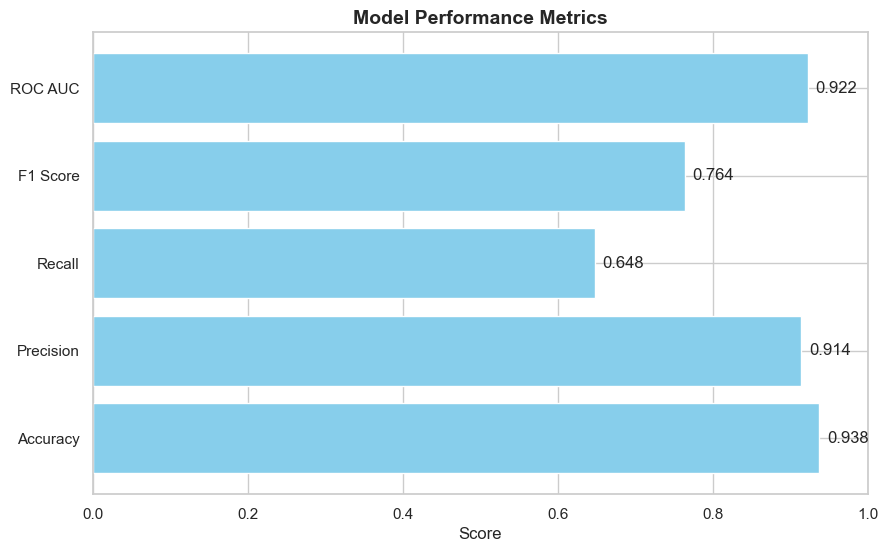

In [32]:
import matplotlib.pyplot as plt

# Data
data = {"Accuracy": 0.93765,
        "Precision": 0.9142411101474414,
        "Recall": 0.6481029263370333,
        "F1 Score": 0.7637810191324115,
        "ROC AUC": 0.9224676526513923}

# Extract keys and values
metrics = list(data.keys())
scores = list(data.values())

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(metrics, scores, color='skyblue')

# Add data labels
for i in range(len(scores)):
    ax.text(scores[i] + 0.01, i, f"{scores[i]:.3f}", va='center')

# Title and labels
ax.set_title("Model Performance Metrics", fontsize=14, fontweight='bold')
ax.set_xlabel("Score")
ax.set_xlim([0, 1])

# Show plot
plt.show()


In [14]:
(print(np.__version__))



1.26.4


### Load Data


In [15]:
 

df = pd.read_csv('data_science_competition_2024.csv')
df.columns
print(df.shape )# (rows, columns)
df.head(4)


(100000, 21)


,Unnamed: 0,loan_id,gender,disbursemet_date,currency,country,sex,is_employed,job,location,...,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults.1,remaining term,salary,marital_status,age.1,Loan Status
0,0,8d05de78-ff32-46b1-aeb5-b3190f9c158a,female,2022 10 29,USD,Zimbabwe,female,True,Teacher,Beitbridge,...,0,48653.011473,0.22,37,0,47,3230.038869,married,37,Did not default
1,1,368bf756-fcf2-4822-9612-f445d90b485b,other,2020 06 06,USD,Zimbabwe,other,True,Teacher,Harare,...,2,28752.062237,0.20,43,2,62,3194.139103,single,43,Did not default
2,2,6e3be39e-49b5-45b5-aab6-c6556de53c6f,other,2023 09 29,USD,Zimbabwe,other,True,Nurse,Gweru,...,1,44797.554126,0.22,43,1,57,3330.826656,married,43,Did not default
3,3,191c62f8-2211-49fe-ba91-43556b307871,female,2022 06 22,USD,Zimbabwe,female,True,Doctor,Rusape,...,0,35681.496413,0.23,47,0,42,2246.797020,divorced,47,Did not default


C:\Users\Augah\AppData\Local\Temp\ipykernel_17172\2655306566.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=missing_values.index, y=missing_values.values, palette="viridis")


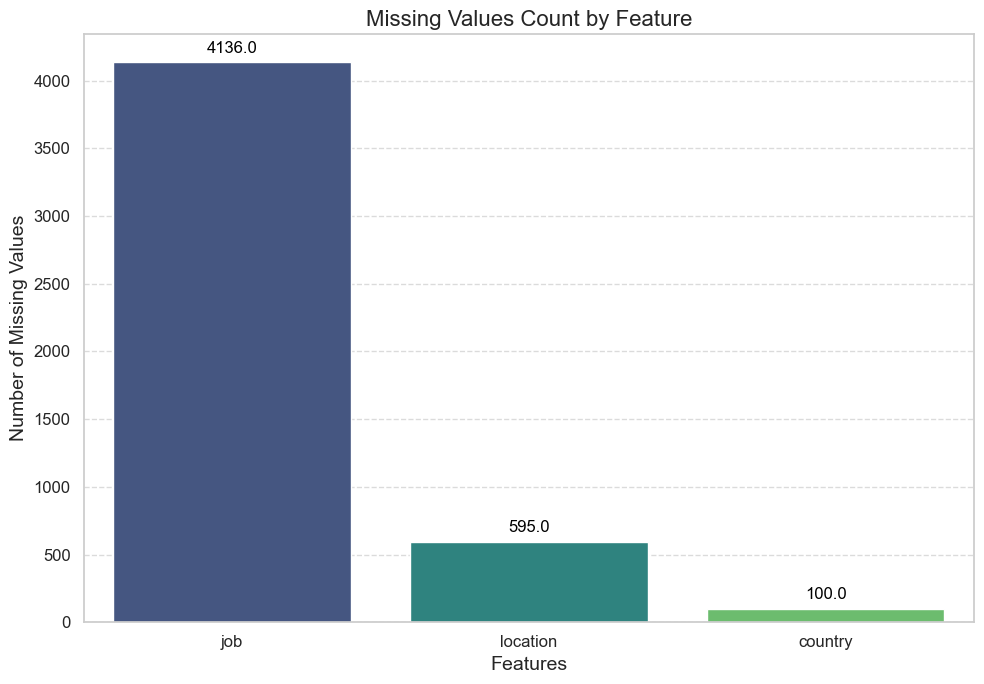

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Count missing values
missing_values = df.isna().sum()[['job', 'location', 'country']]

# Set the style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 7))
ax = sns.barplot(x=missing_values.index, y=missing_values.values, palette="viridis")

# Add title and labels
plt.title('Missing Values Count by Feature', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Number of Missing Values', fontsize=14)

# Add value labels on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=12,
                color='black')

# Customize ticks and grid
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


### Class balance


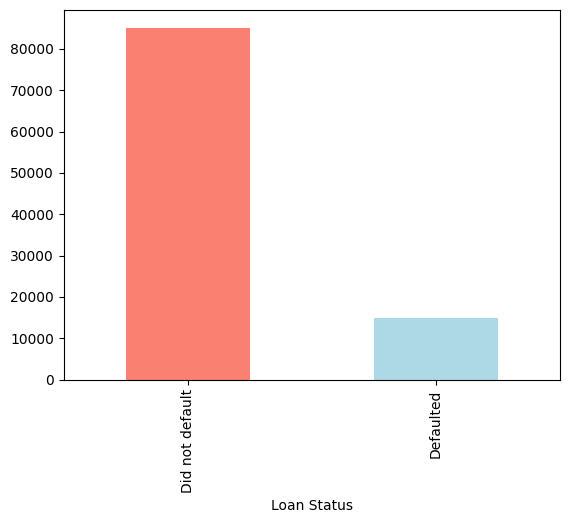

In [5]:

df['Loan Status'].value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

## Structure overview

- The dataset is has 100000 rows and 21 columns.
- It has both categorical and numerical features.
- It is extremely imbalanced
- It has missing values in the `job`, `location` and `country` columns


# PRIMARY DATA CLEANING


### Feature data type correction


In [6]:
df.dtypes

Unnamed: 0                int64
loan_id                  object
gender                   object
disbursemet_date         object
currency                 object
country                  object
sex                      object
is_employed                bool
job                      object
location                 object
loan_amount             float64
number_of_defaults        int64
outstanding_balance     float64
interest_rate           float64
age                       int64
number_of_defaults.1      int64
remaining term           object
salary                  float64
marital_status           object
age.1                     int64
Loan Status              object
dtype: object

* remaining term data type looks suspicious since its labeled object yet it should be integer.

In [7]:
import pandas as pd


# Identify categorical columns
categorical_cols = ['job', 'location', 'marital_status', 'gender']

# Print value counts for each categorical column
for col in categorical_cols:
    print(f"Value counts for '{col}':")
    print(df[col].value_counts())
    print()


Value counts for 'job':
job
Engineer              16524
Nurse                 15284
Data Analyst          13204
Doctor                12186
Software Developer    11932
Teacher                8950
Accountant             7802
SoftwareDeveloper      3564
Data Scientist         3521
Lawyer                 2862
Data Scintist            35
Name: count, dtype: int64

Value counts for 'location':
location
Harare               8338
Bulawayo             8078
Mutare               8062
Gweru                7803
Masvingo             7476
                     ... 
 Redcliff               1
Victoria Falls          1
Victoria Falls          1
   Gokwe                1
Gokwe                   1
Name: count, Length: 157, dtype: int64

Value counts for 'marital_status':
marital_status
married     44710
divorced    26465
single      25698
             3127
Name: count, dtype: int64

Value counts for 'gender':
gender
male      35028
female    32685
other     32287
Name: count, dtype: int64



### From the above we can see that there is 
1. Incorrect spellings further differentiating same categories in the `location`, `job` `currency` and `country`.
2. There is an additional unlabeled white space in the `marital_status` column.
3. `Remaining term` contains a mixture of both strings and integers. 

### Convert remaining term dtype

In [8]:
#Convert remaining term feature to consitenly become numeric

# Convert to string to handle non-numeric characters
df['remaining term'] = df['remaining term'].astype(str)

# Remove underscores and extra spaces
df['remaining term'] = df['remaining term'].str.replace('_', '').str.strip()

# Convert back to numeric if all values are intended to be numeric
df['remaining term'] = pd.to_numeric(df['remaining term'], errors='coerce')


df['remaining term'].dtype


dtype('int64')

* converted the **remaining term** data type

### Feature category spelling correction


In [9]:
print(df['location'].value_counts().sort_values().to_string())
#incorrect spellings for locations


location
Gokwe                    1
   Zvishavane            1
 Victoria Falls          1
   Gokwe                 1
Victoria Falls           1
 Redcliff                1
Victoria Falls           1
 Zvishavane              2
Gokwe                    2
 Victoria Falls          2
 Gokwe                   2
   Kariba                2
   Kariba                3
   Redcliff              3
   Victoria Falls        3
 Kariba                  3
 Kariba                  3
Kariba                   4
Kariba                   4
   Shurugwi              4
   Zvishavane            4
Kadoma                   5
 Shurugwi                5
   Nyanga                5
 Nyanga                  5
   Kadoma                6
Zvishavane               6
   Shurugwi              6
 Gokwe                   6
 Zvishavane              6
Shurugwi                 6
Zvishavane               6
   Karoi                 6
 Shurugwi                7
Karoi                    7
   Gokwe                 7
 Karoi             

### Correct and normalize location spellings

In [10]:
#location feature textual normalization
df['location'] = df['location'].str.strip()

# convert lowercase
df['location'] = df['location'].str.lower()

# Create a dictionary to map incorrect variations to correct values
mapping = {
    'harare': 'Harare',
    'bulawayo': 'Bulawayo',
    'mutare': 'Mutare',
    'gweru': 'Gweru',
    'masvingo': 'Masvingo',
    'marondera': 'Marondera',
    'rusape': 'Rusape',
    'chivhu': 'Chivhu',
    'plumtree': 'Plumtree',
    'beitbridge': 'Beitbridge',
    'chipinge': 'Chipinge',
    'chimanimani': 'Chimanimani',
    'kwekwe': 'Kwekwe',
    'chiredzi': 'Chiredzi',
    'kadoma': 'Kadoma',
    'nyanga': 'Nyanga',
    'karoi': 'Karoi',
    'shurugwi': 'Shurugwi',
    'zvishavane': 'Zvishavane',
    'gokwe': 'Gokwe',
    'kariba': 'Kariba',
    'victoria falls': 'Victoria Falls',
    'redcliff': 'Redcliff',
    'hwange': 'Hwange'
}

# Replace incorrect values using the mapping dictionary
df['location'] = df['location'].replace(mapping)



print(df['location'].value_counts())
# the locations are now normalized


location
Harare            8553
Bulawayo          8263
Mutare            8262
Gweru             7983
Masvingo          7665
Marondera         7513
Rusape            6506
Chivhu            6411
Plumtree          5552
Beitbridge        5311
Chipinge          4447
Chimanimani       4388
Kwekwe            3491
Chiredzi          3199
Kadoma            3118
Nyanga            2142
Karoi             1899
Shurugwi          1359
Zvishavane        1301
Gokwe              920
Kariba             671
Victoria Falls     219
Redcliff           191
Hwange              41
Name: count, dtype: int64


### Correct category spellings for currency, country and job.


In [11]:
print(df.currency.value_counts())
print()
print(df['country'].value_counts())
print()
print(df['job'].value_counts())
#Textual normalization required

currency
USD     99980
$USD       20
Name: count, dtype: int64

country
Zimbabwe    99787
zimbabwe      100
Zim            13
Name: count, dtype: int64

job
Engineer              16524
Nurse                 15284
Data Analyst          13204
Doctor                12186
Software Developer    11932
Teacher                8950
Accountant             7802
SoftwareDeveloper      3564
Data Scientist         3521
Lawyer                 2862
Data Scintist            35
Name: count, dtype: int64


In [12]:
# function to correct spelling
def consistent_column_spelling(column, current_label, correctlabel):
    df.loc[df[column]== current_label, column] = correctlabel

In [13]:
#correcting feature categories

def consistent_column_spelling(column, current_label, correctlabel):
    df.loc[df[column]== current_label, column] = correctlabel
    return df.loc[:, column].value_counts()

consistent_column_spelling('currency', '$USD', 'USD')
consistent_column_spelling('job', 'Data Scintist', 'Data Scientist')
consistent_column_spelling('job', 'SoftwareDeveloper', 'Software Developer')
consistent_column_spelling('country', 'Zimbabwe', 'zimbabwe')
consistent_column_spelling('country', 'Zim', 'zimbabwe')

print(df.currency.value_counts())
print()
print(df['country'].value_counts())
print()
print(df['job'].value_counts())

currency
USD    100000
Name: count, dtype: int64

country
zimbabwe    99900
Name: count, dtype: int64

job
Engineer              16524
Software Developer    15496
Nurse                 15284
Data Analyst          13204
Doctor                12186
Teacher                8950
Accountant             7802
Data Scientist         3556
Lawyer                 2862
Name: count, dtype: int64


* Columns normalized

Drop unnecessary and redundant columns


In [14]:
# Drop unnecessary columns
df.drop(['loan_id', 'Unnamed: 0', 'age.1', 'number_of_defaults.1', 'sex'], axis=1, inplace=True)

# EXPLORATORY DATA ANALYSIS

#### The goal here is to find out more about the data and become a subject matter expert.

1. What question(s) are you trying to solve?
2. What kind of data do we have and how do we treat different types?
3. What's missing from the data and how do you deal with it?
4. Where are the outliers and why should you care about them?
5. How can you add, change or remove features to get more out of your data?


In [15]:
df.describe()

,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining term,salary
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,31120.000000,0.441970,36964.909763,0.210435,43.57069,52.881870,2781.804324
std,15895.093631,0.688286,10014.758477,0.018725,4.86376,11.985833,696.450055
min,1000.000000,0.000000,0.000000,0.100000,21.00000,0.000000,250.000000
25%,21000.000000,0.000000,29625.227472,0.200000,40.00000,45.000000,2273.929349
50%,31000.000000,0.000000,35063.852394,0.210000,44.00000,52.000000,2665.441567
75%,40000.000000,1.000000,42133.388817,0.220000,47.00000,61.000000,3146.577655
max,273000.000000,2.000000,150960.000000,0.300000,65.00000,120.000000,10000.000000


In [16]:
print(df.shape)
print()
print(df.isna().sum())

(100000, 16)

gender                    0
disbursemet_date          0
currency                  0
country                 100
is_employed               0
job                    4136
location                595
loan_amount               0
number_of_defaults        0
outstanding_balance       0
interest_rate             0
age                       0
remaining term            0
salary                    0
marital_status            0
Loan Status               0
dtype: int64


### Univariate relationships

- identify the distribution of the individual features


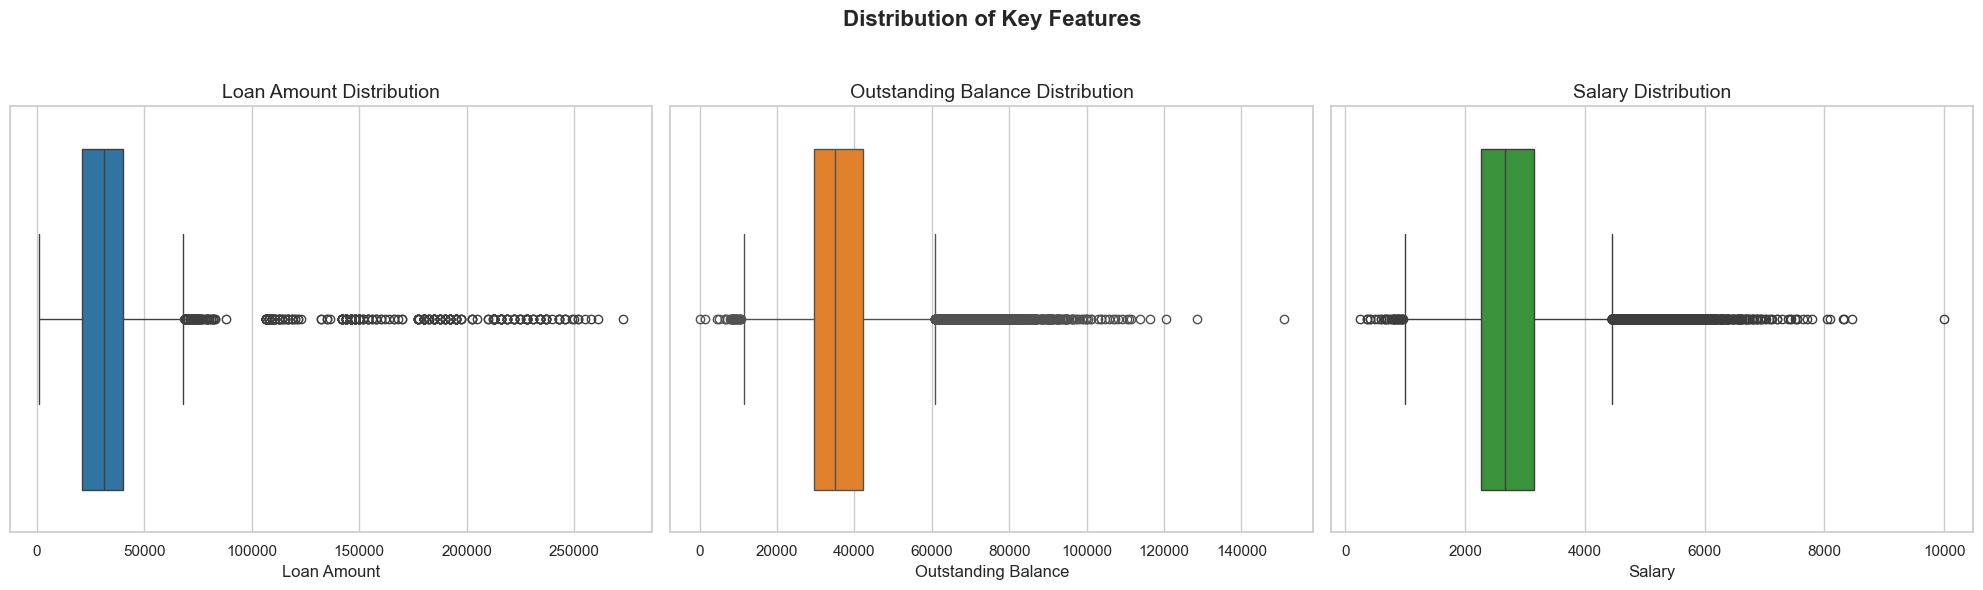

In [21]:
# univariate hist plots
# fig, (ax,ax1) = plt.subplots(2,3,figsize=(20,8))
# plt.suptitle('DISTRIBUTION PLOTS')
# sns.histplot(df,x= 'age', bins=100,kde=True, ax=ax[0], color='darkcyan');
# sns.histplot(df,x = 'interest_rate', bins=100,kde=True, ax=ax[1], color='salmon');
# sns.histplot(df, x = 'salary', bins=100,kde=True, ax=ax[2], color='darkviolet');
# sns.histplot(df, x = 'outstanding_balance', bins=100,kde=True, ax=ax1[0], color='yellow');
# sns.histplot(df, x = 'remaining term', bins=100,kde=True, ax=ax1[1], color='gold');
# sns.histplot(df, x = 'loan_amount', bins=100,kde=True, ax=ax1[2], color='darkgoldenrod');

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
plt.suptitle('Distribution of Key Features', fontsize=16, weight='bold')

# Define colors for each plot
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Box plot for loan_amount
sns.boxplot(data=df, x='loan_amount', ax=ax[0], color=colors[0])
ax[0].set_title('Loan Amount Distribution', fontsize=14)
ax[0].set_xlabel('Loan Amount', fontsize=12)

# Box plot for outstanding_balance
sns.boxplot(data=df, x='outstanding_balance', ax=ax[1], color=colors[1])
ax[1].set_title('Outstanding Balance Distribution', fontsize=14)
ax[1].set_xlabel('Outstanding Balance', fontsize=12)

# Box plot for salary
sns.boxplot(data=df, x='salary', ax=ax[2], color=colors[2])
ax[2].set_title('Salary Distribution', fontsize=14)
ax[2].set_xlabel('Salary', fontsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust title position

# Show the plot
plt.show()




#### Observations

- age, interest rate are uniformly distributed.
- outstanding balance, loan amount, salary and outstanding balance are skewed.
- Loan amount has a sharp peak at the start.
- outstanding balance and salary have considerable outliers.


#### Further investigate the sharp peak on loan amount distribution.


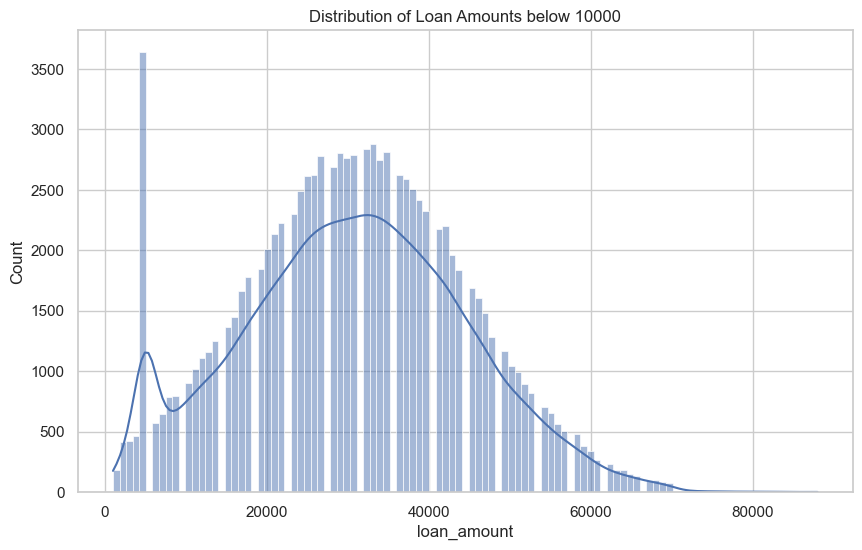

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(df[df['loan_amount']<100000]['loan_amount'], kde=True)
plt.title('Distribution of Loan Amounts below 10000')
plt.show()

C:\Users\Augah\AppData\Local\Temp\ipykernel_17172\3721305379.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='loan_>_75000', y='default', data=default_rates, palette='viridis')
C:\Users\Augah\AppData\Local\Temp\ipykernel_17172\3721305379.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='loan_>_75000', y='default', data=default_rates, palette='viridis')


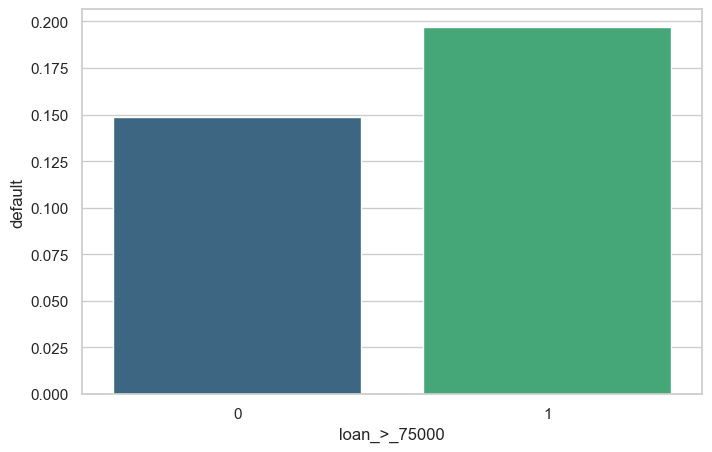

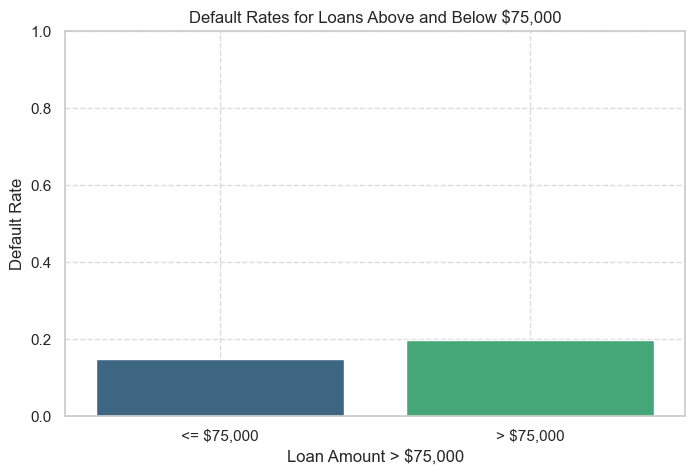

In [29]:
df['loan_>_75000'] = np.where(df['loan_amount'] > 75000, 1, 0)
# Calculate default rates based on the binary feature
df['default'] = df['Loan Status'].map({"Did not default": 0, "Defaulted": 1})
default_rates = df.groupby('loan_>_75000')['default'].mean().reset_index()
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(x='loan_>_75000', y='default', data=default_rates, palette='viridis')
default_rates = df.groupby('loan_>_75000')['default'].mean().reset_index()
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(x='loan_>_75000', y='default', data=default_rates, palette='viridis')

plt.xlabel('Loan Amount > $75,000')
plt.ylabel('Default Rate')
plt.title('Default Rates for Loans Above and Below $75,000')
plt.xticks([0, 1], ['<= $75,000', '> $75,000'])
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'yaxis'

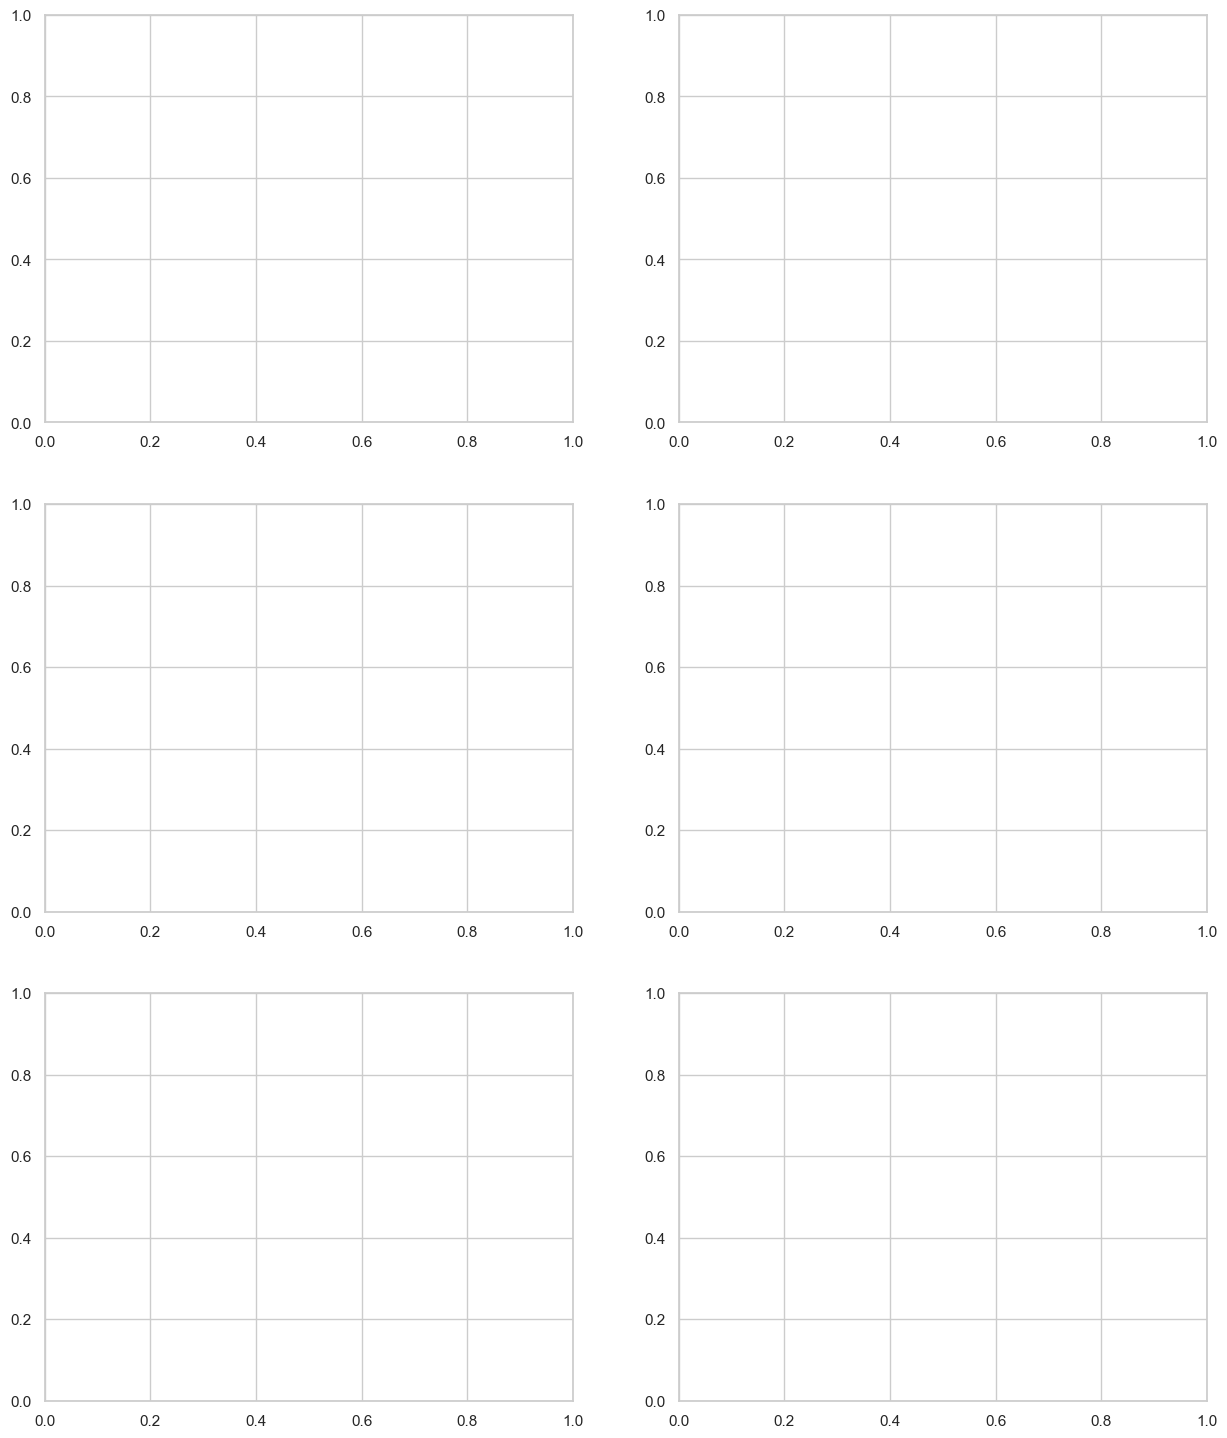

In [25]:
fig, (ax) = plt.subplots(3,2,figsize=(15,18));
sns.countplot(df,x= 'job', ax=ax[0], palette='crest', hue='Loan Status');
sns.countplot(df,x= 'location', ax=ax[1], palette='mako', hue='Loan Status', );

- There is indeed a sharp peak at around $5000. Indicates a high number of points there.


### Test if the numerical features are normally distributed using qqplots.


In [ ]:
import statsmodels.graphics.gofplots as sm

plt.figure(figsize = (20,16));

fig, ((ax, ax1), (ax2,ax3), (ax4,ax5)) = plt.subplots(nrows=3, ncols=2, figsize = (15,12));
       
sm.qqplot(df['interest_rate'], line='s', ax=ax);  # 's' for straight reference line
plt.xlabel('Theoretical Quantiles')
ax.set_ylabel('interest rates Quantiles')

sm.qqplot(df['salary'], line='s', ax=ax1);  # 's' for straight reference line
plt.xlabel('Theoretical Quantiles')
ax1.set_ylabel('salary Quantiles')

sm.qqplot(df['age'], line='s', ax=ax2);  # 's' for straight reference line
plt.xlabel('Theoretical Quantiles')
ax2.set_ylabel('age Quantiles')

sm.qqplot(df['loan_amount'], line='s', ax=ax3);  # 's' for straight reference line
plt.xlabel('Theoretical Quantiles')
ax3.set_ylabel('loan amount Quantiles')

sm.qqplot(df['remaining term'], line='s', ax=ax4);  # 's' for straight reference line
plt.xlabel('Theoretical Quantiles')
ax4.set_ylabel('remaining term Quantiles');
sm.qqplot(df['outstanding_balance'], line='s', ax=ax5);  # 's' for straight reference line
plt.xlabel('Theoretical Quantiles')
ax5.set_ylabel('outstanding balance Quantiles');
       

<Figure size 2000x1600 with 0 Axes>

Error in callback <function flush_figures at 0x0000017C38CB94E0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 


* **Loan amount** , **salary** and **outstanding balance** are highly deviating away from theoretical  
quantiles (red lines) and therefore they are not normally distributed.

## Bivariate relationships


### Countplots

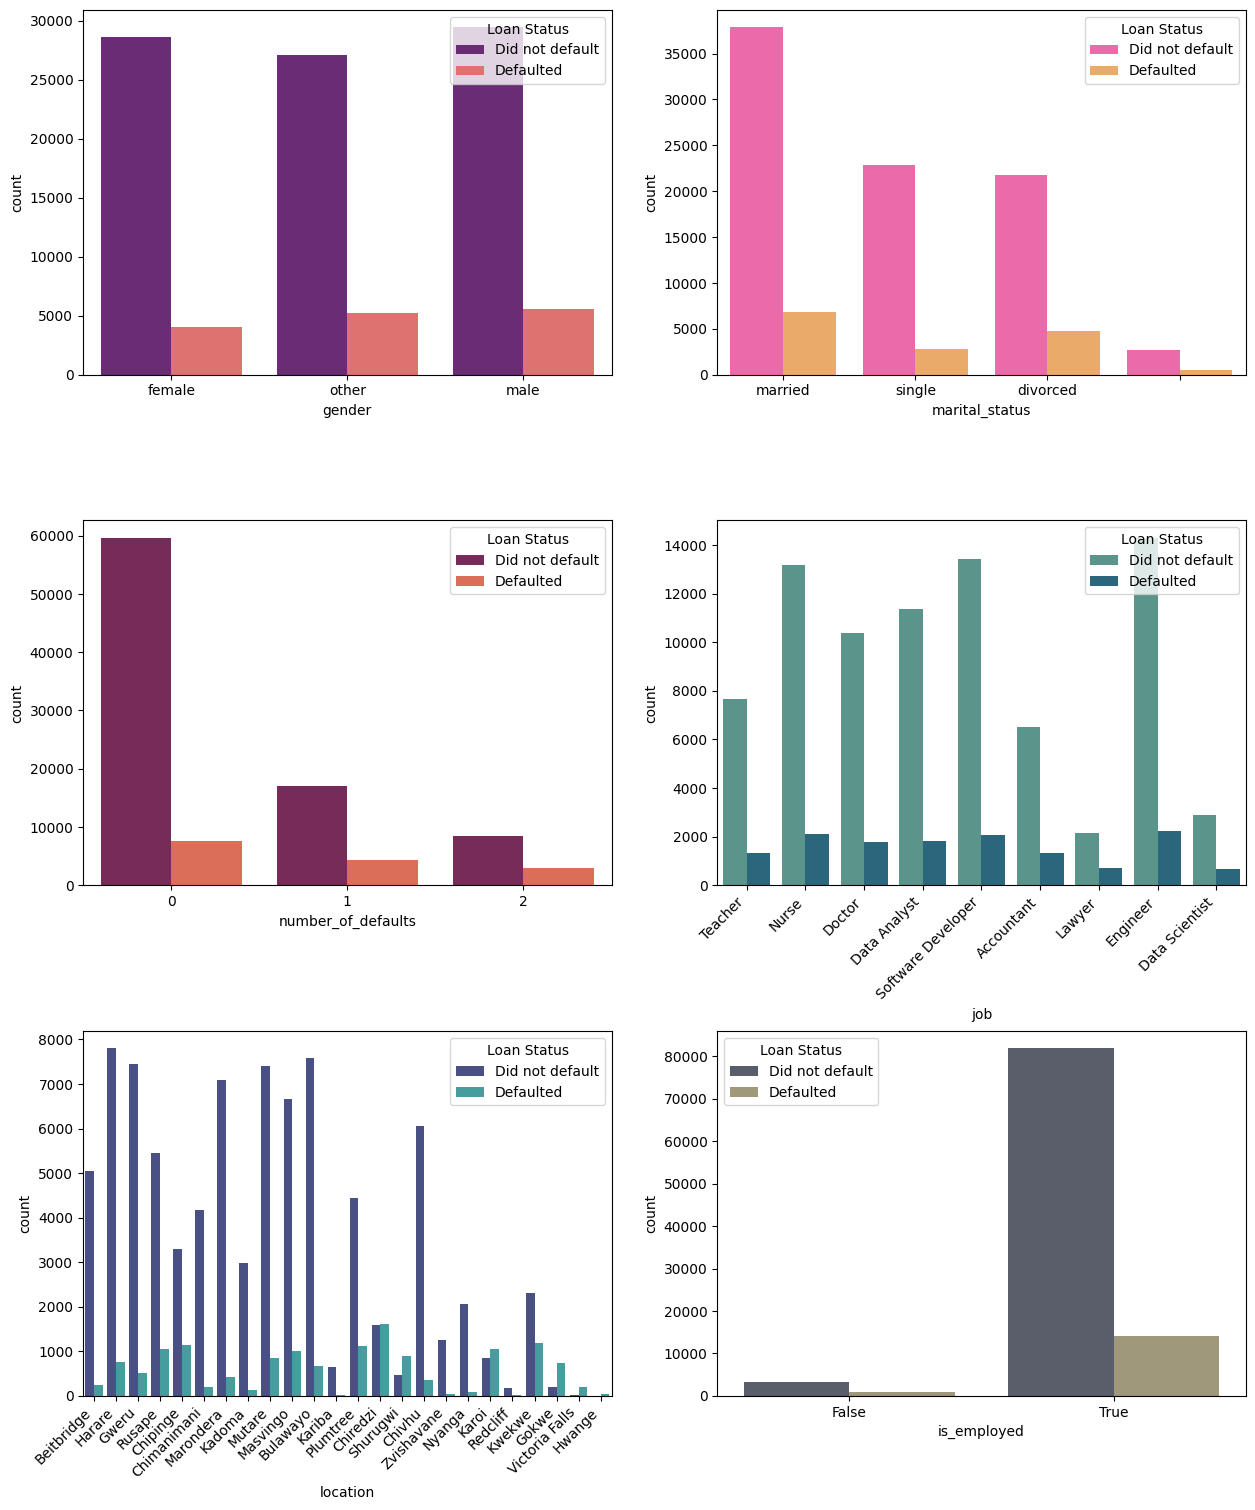

In [ ]:
fig, (ax, ax1, ax2) = plt.subplots(3,2,figsize=(15,18));

sns.countplot(df,x= 'gender', ax=ax[0], palette='magma', hue='Loan Status');
sns.countplot(df,x= 'marital_status', ax=ax[1], palette='spring', hue='Loan Status');
sns.countplot(df,x= 'number_of_defaults', ax=ax1[0], palette='rocket', hue='Loan Status');
sns.countplot(df,x= 'job', ax=ax1[1], palette='crest', hue='Loan Status');
sns.countplot(df,x= 'location', ax=ax2[0], palette='mako', hue='Loan Status', );
sns.countplot(df,x= 'is_employed', ax=ax2[1], palette='cividis', hue='Loan Status', );
ax2[0].set_xticks(ax2[0].get_xticks());
ax1[1].set_xticks(ax1[1].get_xticks());
ax2[0].set_xticklabels(ax2[0].get_xticklabels(), rotation=45, ha='right');
ax1[1].set_xticklabels(ax1[1].get_xticklabels(), rotation=45, ha='right');
plt.subplots_adjust(hspace=0.4)

#### Observations

- Towns like Chiredzi, Shurugwi, Gokwe, Karoi, Hwange and Kwekwe have high probability of defaulting.
- Cities like Harare, Bulawayo, 'Mutare', 'Gweru have low probability of Default'.
- People who are married are less likely to deafulted.
- People with less previous defaults are less likely to deasex is roughly balanced.
- There is an additional unlabeled marital status category.
- Lawyers and Accountants have high probability of defaulting.


## Lineplots

KeyboardInterrupt: 

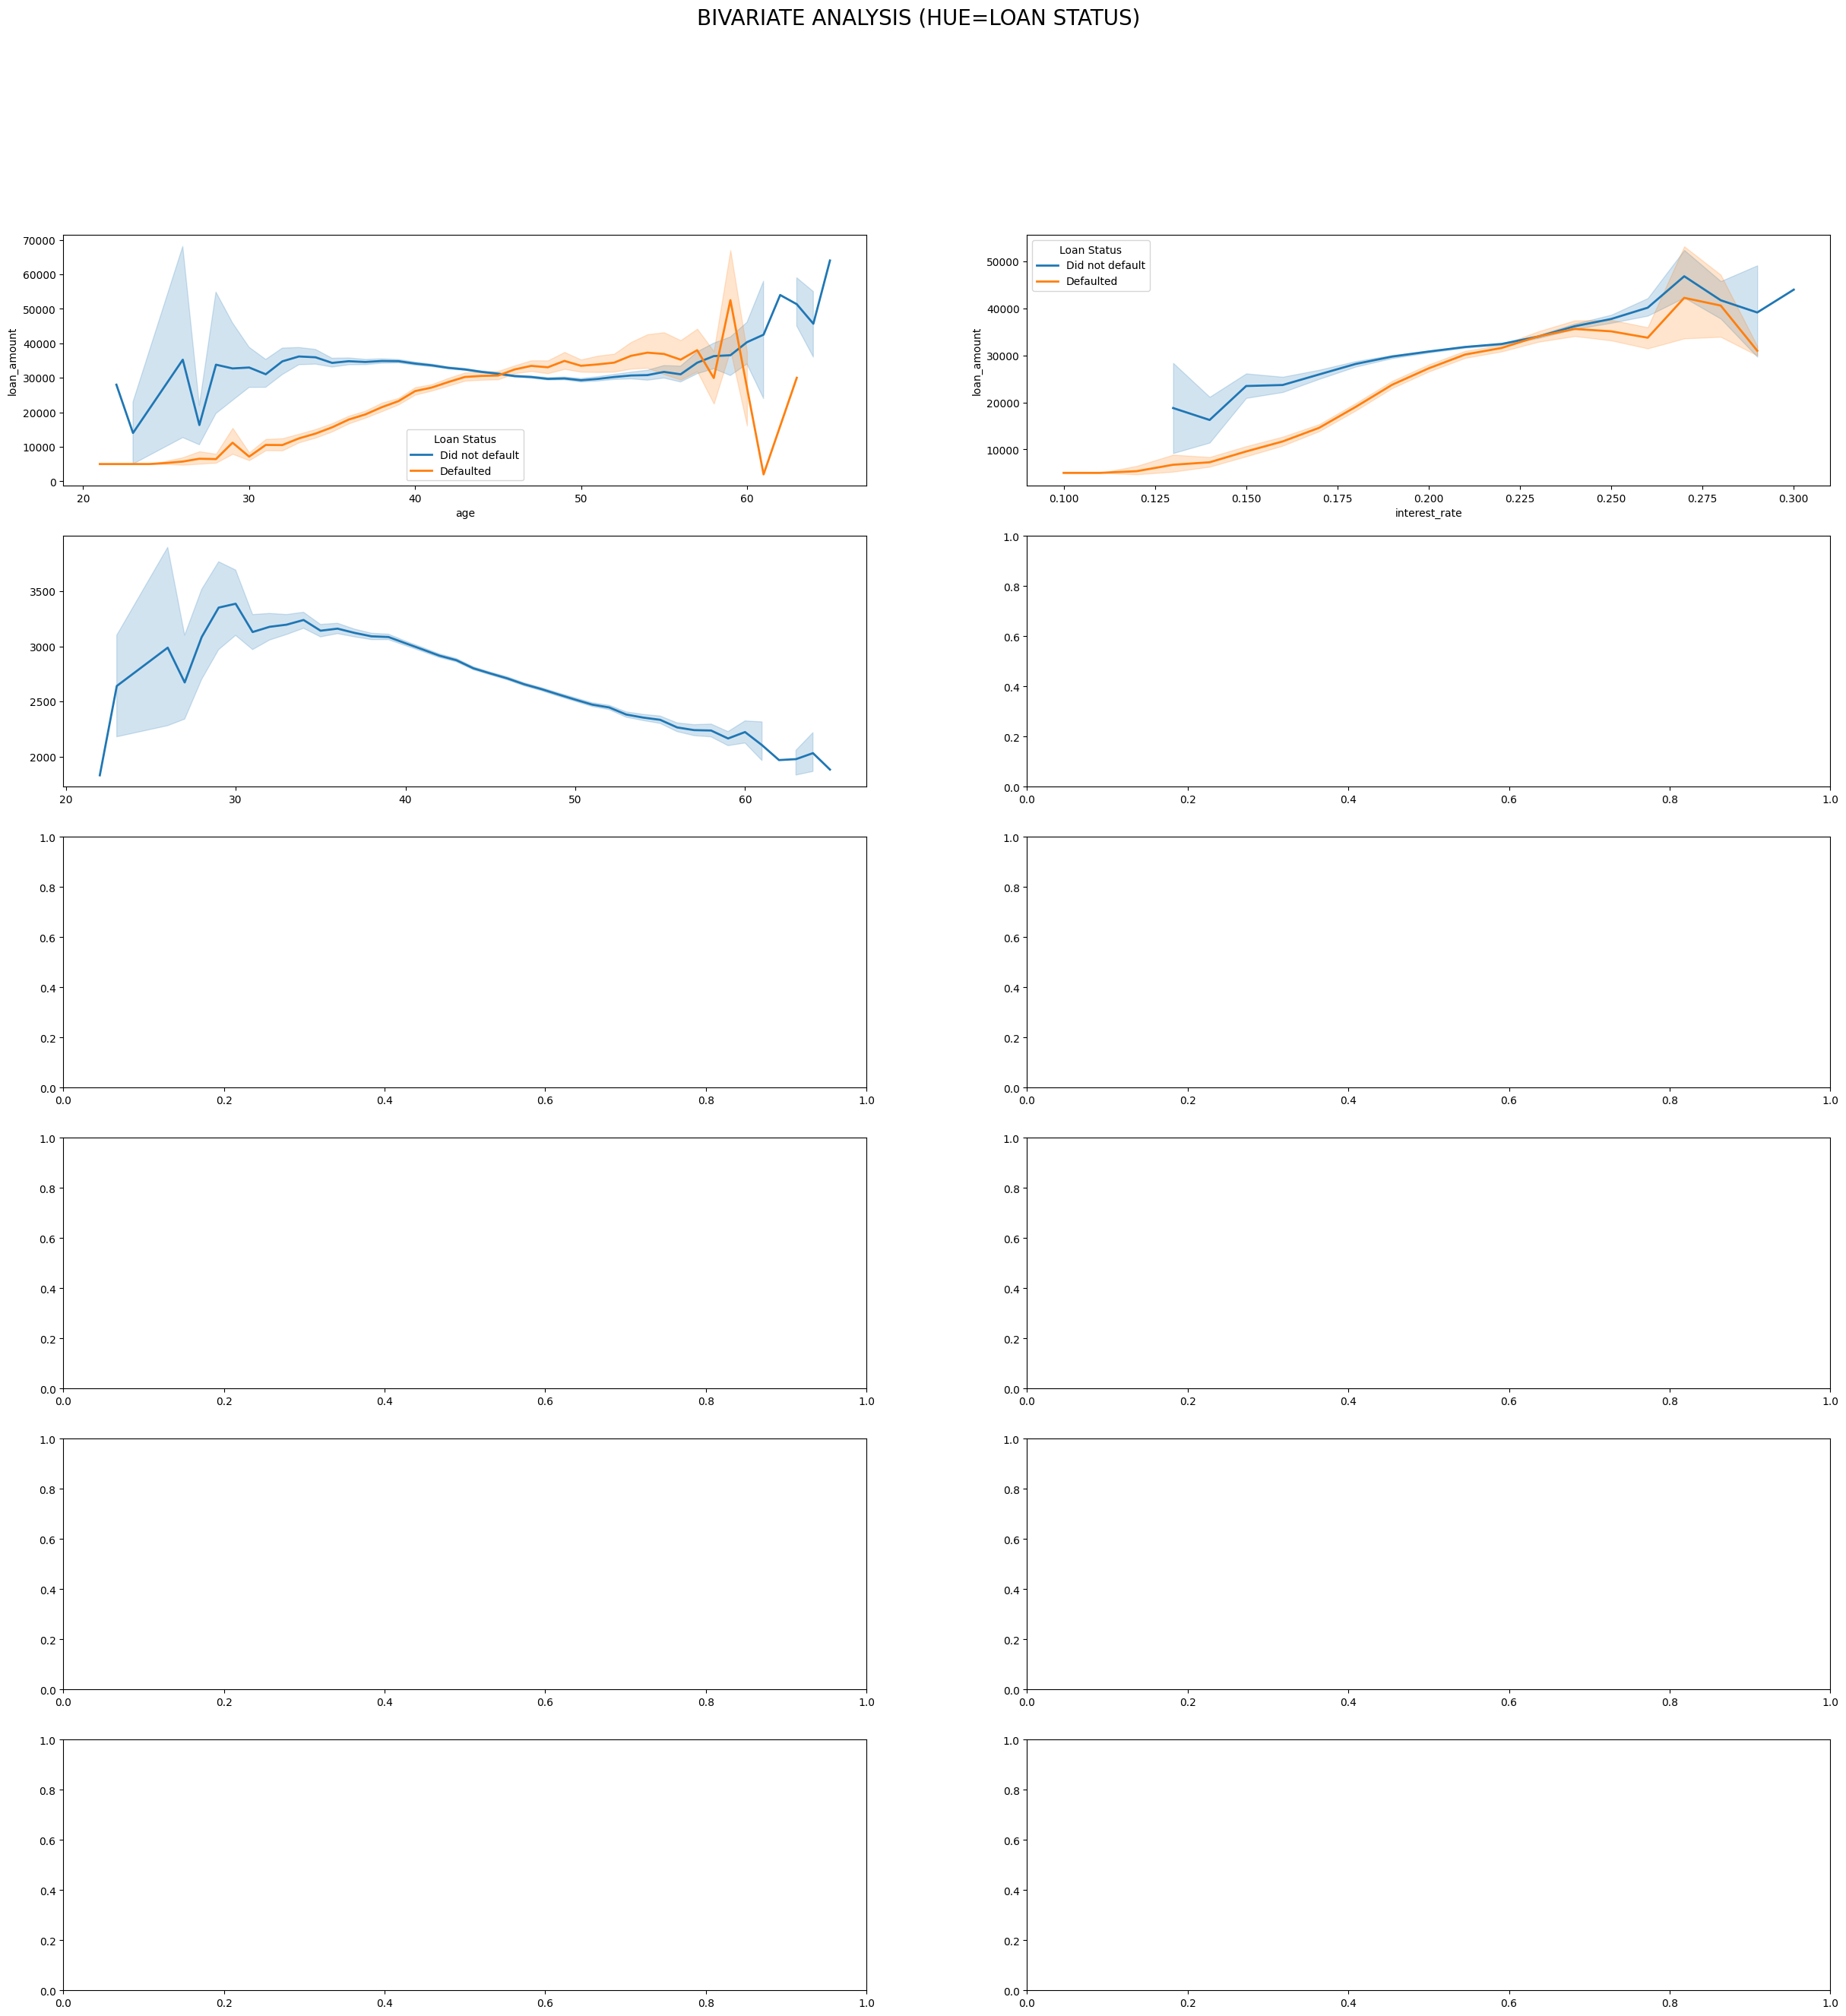

In [ ]:
fig, (ax, ax1, ax2, ax3, ax4,ax5) = plt.subplots(6,2,figsize=(30,30))

plt.suptitle('BIVARIATE ANALYSIS (HUE=LOAN STATUS)', fontsize=20)
sns.lineplot(data=df, x='age', y='loan_amount', hue='Loan Status', lw=2, ax=ax[0]);
sns.lineplot(data=df, x='interest_rate', y='loan_amount', hue='Loan Status', lw=2, ax=ax[1]);
sns.lineplot(data=df, x='age', y='salary', hue='Loan Status', lw=2, ax=ax1[0]);
sns.lineplot(data=df, x='interest_rate', y='age', hue='Loan Status', lw=2, ax=ax1[1]);
sns.lineplot(data=df, x='interest_rate', y='remaining term', hue='Loan Status', lw=2, ax=ax2[0]);
sns.lineplot(data=df, x='age', y='remaining term', hue='Loan Status', lw=2, ax=ax2[1]);
sns.lineplot(data=df, x='age', y='loan_amount', hue='Loan Status', lw=2, ax=ax3[0]);
sns.lineplot(data=df, x='interest_rate', y='salary', hue='Loan Status', lw=2, ax=ax3[1]);
sns.lineplot(data=df, x='age', y='salary', hue='Loan Status', lw=2, ax=ax4[0]);
sns.lineplot(data=df, x='loan_amount', y='salary', hue='Loan Status', lw=2, ax=ax4[1]);
sns.lineplot(data=df, x='remaining term', y='salary', hue='Loan Status', lw=2, ax=ax5[0]);
sns.lineplot(data=df, x='remaining term', y='loan_amount', hue='Loan Status', lw=2, ax=ax5[1]);

#### Observations

* The age vs loan_amount seems to be to seperate classes well in the first half.
* The interest rate vs loan_amount seems to be to seperate classes well in the first 3 quarter.
* Age is also a good seperator with salary.
* Remaining term is also good in the last quarter.
* Remaining term vs salary for deaulted and not defaulted increasing at the same rate.

## Multivariate relationships


<Axes: >

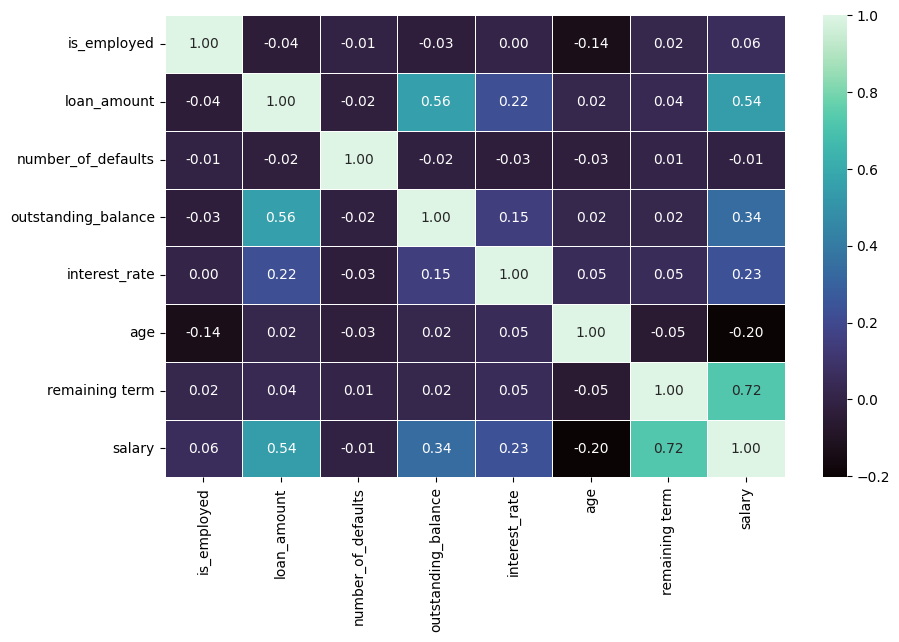

In [17]:
corrData = df.loc[:, [col for col in df if df[col].dtype not in ['category', 'object']]]
plt.figure(figsize=(10,6))
sns.heatmap(corrData.corr(), annot= True, linewidths=0.5,
                 fmt=".2f",
                 cmap="mako")


### There is considerable  is correlation between:-

* **salary** and **loan amount**,  
* **salary** and **loan remaining term**,
* **loan amount** and **outstanding_balance**


# SECONDARY DATA HANDLING

## HANDLING MISSING VALUES


In [18]:
df.isna().sum()

gender                    0
disbursemet_date          0
currency                  0
country                 100
is_employed               0
job                    4136
location                595
loan_amount               0
number_of_defaults        0
outstanding_balance       0
interest_rate             0
age                       0
remaining term            0
salary                    0
marital_status            0
Loan Status               0
dtype: int64

In [19]:

# fill job with median job
df.job.fillna('Data Analyst',inplace= True)
#fill with unknown for location
df.location.fillna('unknown',inplace= True)


df.isna().sum()
df1 = df.copy()

C:\Users\Augah\AppData\Local\Temp\ipykernel_22752\3365732677.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.job.fillna('Data Analyst',inplace= True)
C:\Users\Augah\AppData\Local\Temp\ipykernel_22752\3365732677.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

## Earlier

- Earlier we discovered that the marital status feature has a category called " " white space.
- We want to predict this category into its corresponding valid category using the XGB MODEL.
- We are going to use the custom made predict feature class.


## Data preprocessing


In [20]:
#Create a column to seperate Indutrial, Towns and the rest

df['Category'] = df['location'].apply(lambda x: 
                                     
                                     2 if x in [
    
    'Karoi',
    'Hwange',
     'Chiredzi',
    'Gokwe',
    'Shurugwi',
    'Victoria Falls',
    
    ] else 0 if x in ['Nyanga', 'Chivhu', 'Kadoma', 'Marondera', 'Gweru', 'Masvingo', 'Harare', 'Bulawayo', 'Mutare'] else 1 )

# copy df for training the pipeline



### Encoding columns

In [21]:
# encode categorical variables

from sklearn.preprocessing import LabelEncoder

df['gender'] = df['gender'].map({"other":1, "female": 0,'male':2}).astype('int')

label_encodings = {}
label_models = {}

# Initialize the LabelEncoder
le = LabelEncoder()

# List of categorical features
categorical_features = ['currency', 'country', 'job', 'location']

# Encode each categorical feature and store the mappings
for cat in categorical_features:
    label_models[cat] = le.fit(df[cat])
    label_encodings[cat] = dict(zip(le.classes_, le.transform(le.classes_)))
    df[cat] = le.fit_transform(df[cat])
    
le.fit([ 'Defaulted','Did not default'])
if df['Loan Status'].dtype != 'int64':
    df['Loan Status'] = df['Loan Status'].map({'Did not default': 0, 'Defaulted': 1}).astype('int')
label_models

# df['marital_status'] = df['marital_status'].map({'single': 0, 'married': 1, 'divorced': 2, ' ':3}).astype('int')


{'currency': LabelEncoder(),
 'country': LabelEncoder(),
 'job': LabelEncoder(),
 'location': LabelEncoder()}

## EARLIER

- Earlier we discovered that the marital status feature has a category called " " white space.
- We want to predict this category into its corresponding valid category using an XGB MODEL.
- We are going to use the custom made predict feature class.


In [22]:
print(np.__version__)

1.26.4


In [23]:

import importlib
import predict_feature
importlib.reload(predict_feature)
from predict_feature import Predict_Marital
import xgboost as xgb





mdl = Predict_Marital(df.drop('disbursemet_date', axis =1))
mdl.train()

preds, feature_importances = mdl.predict()

df.loc[df.marital_status  == ' ', 'marital_status']

df.loc[df.marital_status  == ' ', 'marital_status'] =pd.DataFrame(preds)[0].map({0:'single', 1:'married', 2:'divorced'}).to_numpy()
df['marital_status'] = df['marital_status'].map({'single':0, 'married':1, 'divorced': 2}).astype('int')

print(df.marital_status.value_counts())

X = df.drop(columns=['Loan Status', 'disbursemet_date'])
y = df['Loan Status']

score: 0.8995612903225807
marital_status
1    46184
2    27291
0    26525
Name: count, dtype: int64


## Feature Engineering

#### Create new features


In [24]:
## function to encode a categorical feature ordinaly with respect to another feature with mean
def group_sort_map(X, groupby_column, sort_by_column):
    """
    Group X by a given column, calculate the mean, sort by another column,
    and map the groupby column to its corresponding index after sorting.

    Parameters:
    - X (pd.DataFrame): The input DataFrame to process.
    - groupby_column (str): The column name to group by.
    - sort_by_column (str): The column name to sort by.

    Returns:
    - sorted_groupby_df (pd.DataFrame): The grouped and sorted DataFrame.
    - location_to_index (dict): A mapping of groupby column values to their sorted indices.
    """
    
    # 1. Group by the specified column and calculate the mean
    groupby_df = X.groupby(groupby_column).mean()
    
    # 2. Sort the resulting DataFrame by the specified column
    sorted_groupby_df = groupby_df.sort_values(by=sort_by_column)
    
    # 3. Map the groupby column to its corresponding index after sorting
    feature_to_index = {feature: index for index, feature in enumerate(sorted_groupby_df.index)}
    index_to_feature = {index: feature for index, feature in enumerate(sorted_groupby_df.index)}
    
    
    return  feature_to_index, index_to_feature

# ordinally encode location by loan_amount mean per location
location_map, ind_to_feature_location=group_sort_map(X= X, groupby_column='location', sort_by_column='loan_amount' )
X['location'] = X['location'].map(location_map).astype('int')

# ordinally encode location by loan_amount mean per location
job_map, ind_to_feature_job=group_sort_map(X= X, groupby_column='job', sort_by_column='salary' )
X['job'] = X['job'].map(job_map).astype('int')



In [25]:
# independent binary features for loan_amount === 5000 and greater than 75000
X['loan_equal_5000'] = np.where(X.loan_amount==5000,1,0)
X['loan_>_75000'] = np.where(X.loan_amount>75000,1,0)

In [26]:
# create a feature for loan amount per job
X = X.assign(total_loan_amount_per_job=X.groupby('job')['loan_amount'].transform('mean'))

### Create new feature to capture job and location relationship
X['job_location_interact'] = np.log1p(np.sqrt(X['job']))/(X['location']+1)

**Add the location threshold classification in train data only to avoid data leakage since we are using the target varible**


In [27]:
# Create a feature for threshold classification of locations
def location_thresh_classification(X_features, labels, apply_data, threshold= 0.2):
    X_features = X_features.copy()
    X_features['y'] = labels
    location_ratios = X_features.groupby('location')['y'].mean()
    location_ratios = location_ratios / (1 - location_ratios)
  
    ## Define a threshold for classification (example: 0.2)
    threshold = 0.2
    #drop the labels if features equal to the apply
    if apply_data.shape == X_features.shape:
        X_features.drop('y',axis = 1, inplace = True)
    ## Classify locations based on imbalance ratio

    X_features.drop (columns ='y', axis = 1, inplace = True)
    apply_data['location_class'] = apply_data['location'].map(lambda loc: 1 if location_ratios[loc] < threshold else 0)
    return apply_data


# FEATURE SELECTION



### Checking for association between categorical variables using chi square and p_values.


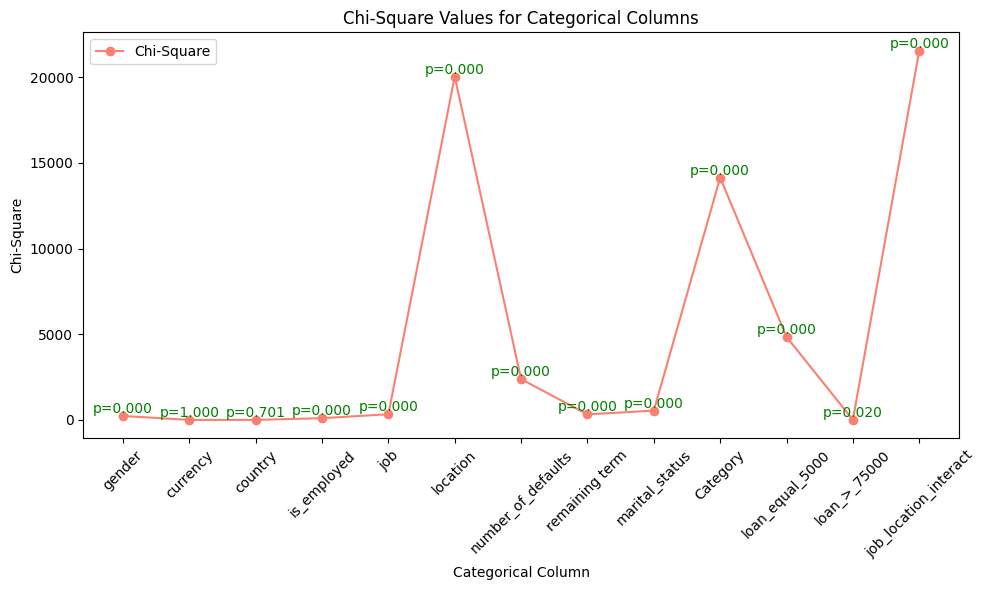

In [31]:
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

# Assume X and y are already defined and preprocessed dataframes
# Initialize the output dictionary
out = {'chi': [], 'p_value': [], 'col': []}

# Iterate over the categorical columns
for i in (X.columns[~X.columns.isin(['loan_amount', 'outstanding_balance', 'salary', 'total_loan_amount_per_job', 'age', 'interest_rate', 'remaining_term'])]):
    # Create a contingency table
    observed_data = pd.crosstab(X[i], y).to_numpy()

    # Perform the Chi-Square test
    chi2_statistic, pval, dof, expected_frequency = chi2_contingency(observed_data)

    # Store the results
    out['chi'].append(chi2_statistic)
    out['p_value'].append(pval)
    out['col'].append(i)

# Create a DataFrame for chi-square values and p-values
chi_X = pd.DataFrame(out)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(chi_X['col'], chi_X['chi'], marker='o', color='salmon', label='Chi-Square')

# Adding p-values as text on the plot
for i, (col, chi, pval) in enumerate(zip(chi_X['col'], chi_X['chi'], chi_X['p_value'])):
    ax.text(i, chi, f'p={pval:.3f}', ha='center', va='bottom', color='green', fontsize=10)

# Adding labels and title
ax.set_xlabel('Categorical Column')
ax.set_ylabel('Chi-Square')
ax.set_title('Chi-Square Values for Categorical Columns')
ax.legend()

plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees for better readability
plt.tight_layout()
plt.show()

- **Currency** and **country** have p_values of greater than 0.05 indicating no significance with target variable.
- **Location**, **category** and **job_location_interaction** have very high chi coefficients indicating very strong significance.


#### Using variance thresholds to select features


In [32]:
from sklearn.feature_selection import  VarianceThreshold
from sklearn.linear_model import LassoCV

selector = VarianceThreshold(threshold=0.01)
X_high_variance = selector.fit_transform(X)
X.columns[~X.columns.isin(selector.get_feature_names_out())]



Index(['currency', 'country', 'interest_rate', 'loan_>_75000'], dtype='object')

In [33]:
from sklearn.feature_selection import RFE


model = RandomForestClassifier(n_estimators=100)
rfe = RFE(model, n_features_to_select=12)
fit = rfe.fit(X, y)
selected_features_rfe = X.columns[~fit.support_]
selected_features_rfe

KeyboardInterrupt: 

- `currency` and `country` are in every selection method and should be removed.


In [ ]:
X.drop(columns=[ 'country', 'currency'], inplace= True)

# PREDICTIVE MODELLING

## MODEL SELECTION

We are going to try the following algorithms.

1. Catboost
2. XGBOOST
3. RandomForestClassier
4. KNearest Neighbours
5. Logistic Regression
6. Decision Tress
7. LightGBM

* We are then going to select our model based on the cross validation score using roc auc score.
* We are going to use five folds.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from lightgbm import LGBMClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import warnings
warnings.filterwarnings('ignore')


# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")
palette = sns.color_palette("Set2")

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fitted_models = []

models = {
    'Logistic Regression': LogisticRegression(verbose=0),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Xgboost': XGBClassifier(),
    'Catboost': CatBoostClassifier(verbose=0),
    'Knn': KNeighborsClassifier(),
    'lightGBM': LGBMClassifier(verbose = 0),
    'Quadratic Discriminant Analysis': QuadraticDiscriminantAnalysis()
}

def cross_val(X, y, show_plots=True, models = models):
    


    scoring = {
        'roc_auc': 'roc_auc',
        'recall': 'recall',
        'precision': 'precision',
        'accuracy': 'accuracy'
    }

    mean_scores = {metric: {} for metric in scoring}
    cv_results = {metric: {} for metric in scoring}

    for name, model in models.items():
        for metric in scoring:
            cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring=scoring[metric])
            cv_results[metric][name] = cv_scores
            mean_scores[metric][name] = cv_scores.mean()
        fitted_models.append(model)

    cv_dfs = {metric: pd.DataFrame(results) for metric, results in cv_results.items()}

    if show_plots:
        fig, axs = plt.subplots(3, 2, figsize=(20, 20))
        fig.suptitle('Cross-Validation Scores for Different Models', fontsize=20, weight='bold')

        metrics = list(cv_dfs.keys())
        for i, metric in enumerate(metrics):
            ax = axs[i // 2, i % 2]
            sns.boxplot(data=cv_dfs[metric], ax=ax, palette=palette)
            ax.set_title(f'{metric.upper()} Scores', fontsize=14, weight='bold')
            ax.set_xlabel('Model', fontsize=12)
            ax.set_ylabel(f'{metric.upper()} Score', fontsize=12)
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True)

        # Hide any unused subplots
        for j in range(len(metrics), 6):
            fig.delaxes(axs[j // 2, j % 2])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    return mean_scores, cv_results  


### Split and cross validate our data

* We are splitting our data so that we can have a seperate testing set later which is unaltered.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=87)

In [ ]:
d2 = X.copy()
d2['y'] = y


Index(['gender', 'currency', 'country', 'is_employed', 'job', 'location',
       'loan_amount', 'number_of_defaults', 'outstanding_balance',
       'interest_rate', 'age', 'remaining term', 'salary', 'marital_status',
       'Category', 'loan_equal_5000', 'loan_>_75000',
       'total_loan_amount_per_job', 'job_location_interact'],
      dtype='object')

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [ ]:


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt

# Function to calculate centroids for each class
def calculate_centroids(df, class_col, feature_cols):
    centroids = df.groupby(class_col)[feature_cols].mean()
    return centroids.reset_index()

# Function to find nearest n/2 neighbors
def find_nearest_neighbors(df, centroid, feature_cols, n_neighbors):
    distances = np.linalg.norm(df[feature_cols] - centroid[feature_cols].values, axis=1)
    nearest_neighbors = df.iloc[np.argsort(distances)[:n_neighbors]]
    return nearest_neighbors

# Function to predict the class of a new data point
def predict_class(new_point, resultant_centroids, feature_cols):
    # Ensure no NaN values in the inputs
    if new_point[feature_cols].isna().any().any():
        raise ValueError("new_point contains NaN values.")
    if resultant_centroids[feature_cols].isna().any().any():
        raise ValueError("resultant_centroids contains NaN values.")
    
    # Find the nearest centroid to the new point
    nearest_centroid_idx, _ = pairwise_distances_argmin_min(
        new_point[feature_cols].values.reshape(1, -1), 
        resultant_centroids[feature_cols].values
    )
    predicted_class = resultant_centroids.iloc[nearest_centroid_idx[0]]['y']
    return predicted_class

# Generate synthetic data

d2 = d2

# Train-test split
train_df, test_df = train_test_split(d2, test_size=0.3, random_state=42)




# Initialize storage for centroids at each stage
stored_centroids = {0: [], 1: []}

# Recursive function to process and store centroids
def recursive_process(df, class_col, feature_cols, n_neighbors):
    if len(df) < n_neighbors:
        return

    centroids = calculate_centroids(df, class_col, feature_cols)
    for _, centroid in centroids.iterrows():
        class_label = centroid[class_col]
        stored_centroids[class_label].append(centroid)

        nearest_neighbors = find_nearest_neighbors(df[df[class_col] == class_label], centroid, feature_cols, n_neighbors)
        recursive_process(nearest_neighbors, class_col, feature_cols, n_neighbors // 2)

d2_cols = d2.columns[~d2.columns.isin(['y'])]
# Starting the recursive process
initial_n_neighbors = len(train_df) // 2
recursive_process(train_df, 'y', d2_cols, initial_n_neighbors)

# Calculate the resultant centroids for each class
resultant_centroids = []
for class_label, centroids in stored_centroids.items():
    if len(centroids) > 0:  # Check if there are any centroids for this class
        average_centroid = pd.DataFrame(centroids).mean()
        average_centroid['y'] = class_label
        resultant_centroids.append(average_centroid)

resultant_centroids_df = pd.DataFrame(resultant_centroids)

# Predict classes for the test set
test_df['Predicted_Class'] = test_df.apply(lambda row: predict_class(row, resultant_centroids_df, d2_cols), axis=1)

# Calculate and display the accuracy score
accuracy = accuracy_score(test_df['y'], test_df['Predicted_Class'])
print(f'Accuracy of the model: {accuracy:.2f}')

# Visualization of data points, centroids, and the prediction process




Accuracy of the model: 0.59


[y                                1.000000
 gender                           1.113276
 currency                         0.000000
 country                          0.000860
 is_employed                      0.943171
 job                              3.297612
 location                         7.079465
 loan_amount                  25919.293219
 number_of_defaults               0.699904
 outstanding_balance          34749.193083
 interest_rate                    0.201018
 age                             41.530755
 remaining term                  52.956829
 salary                        2606.843858
 marital_status                   1.134479
 Category                         0.978988
 loan_equal_5000                  0.134479
 loan_>_75000                     0.004202
 total_loan_amount_per_job    31176.012456
 job_location_interact            0.201624
 Name: 1, dtype: float64]

In [ ]:
from sklearn.linear_model import LassoCV, LinearRegression
model = KNeighborsClassifier().fit(X_train,y_train)
model.score(X_test, y_test)

0.85235

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in

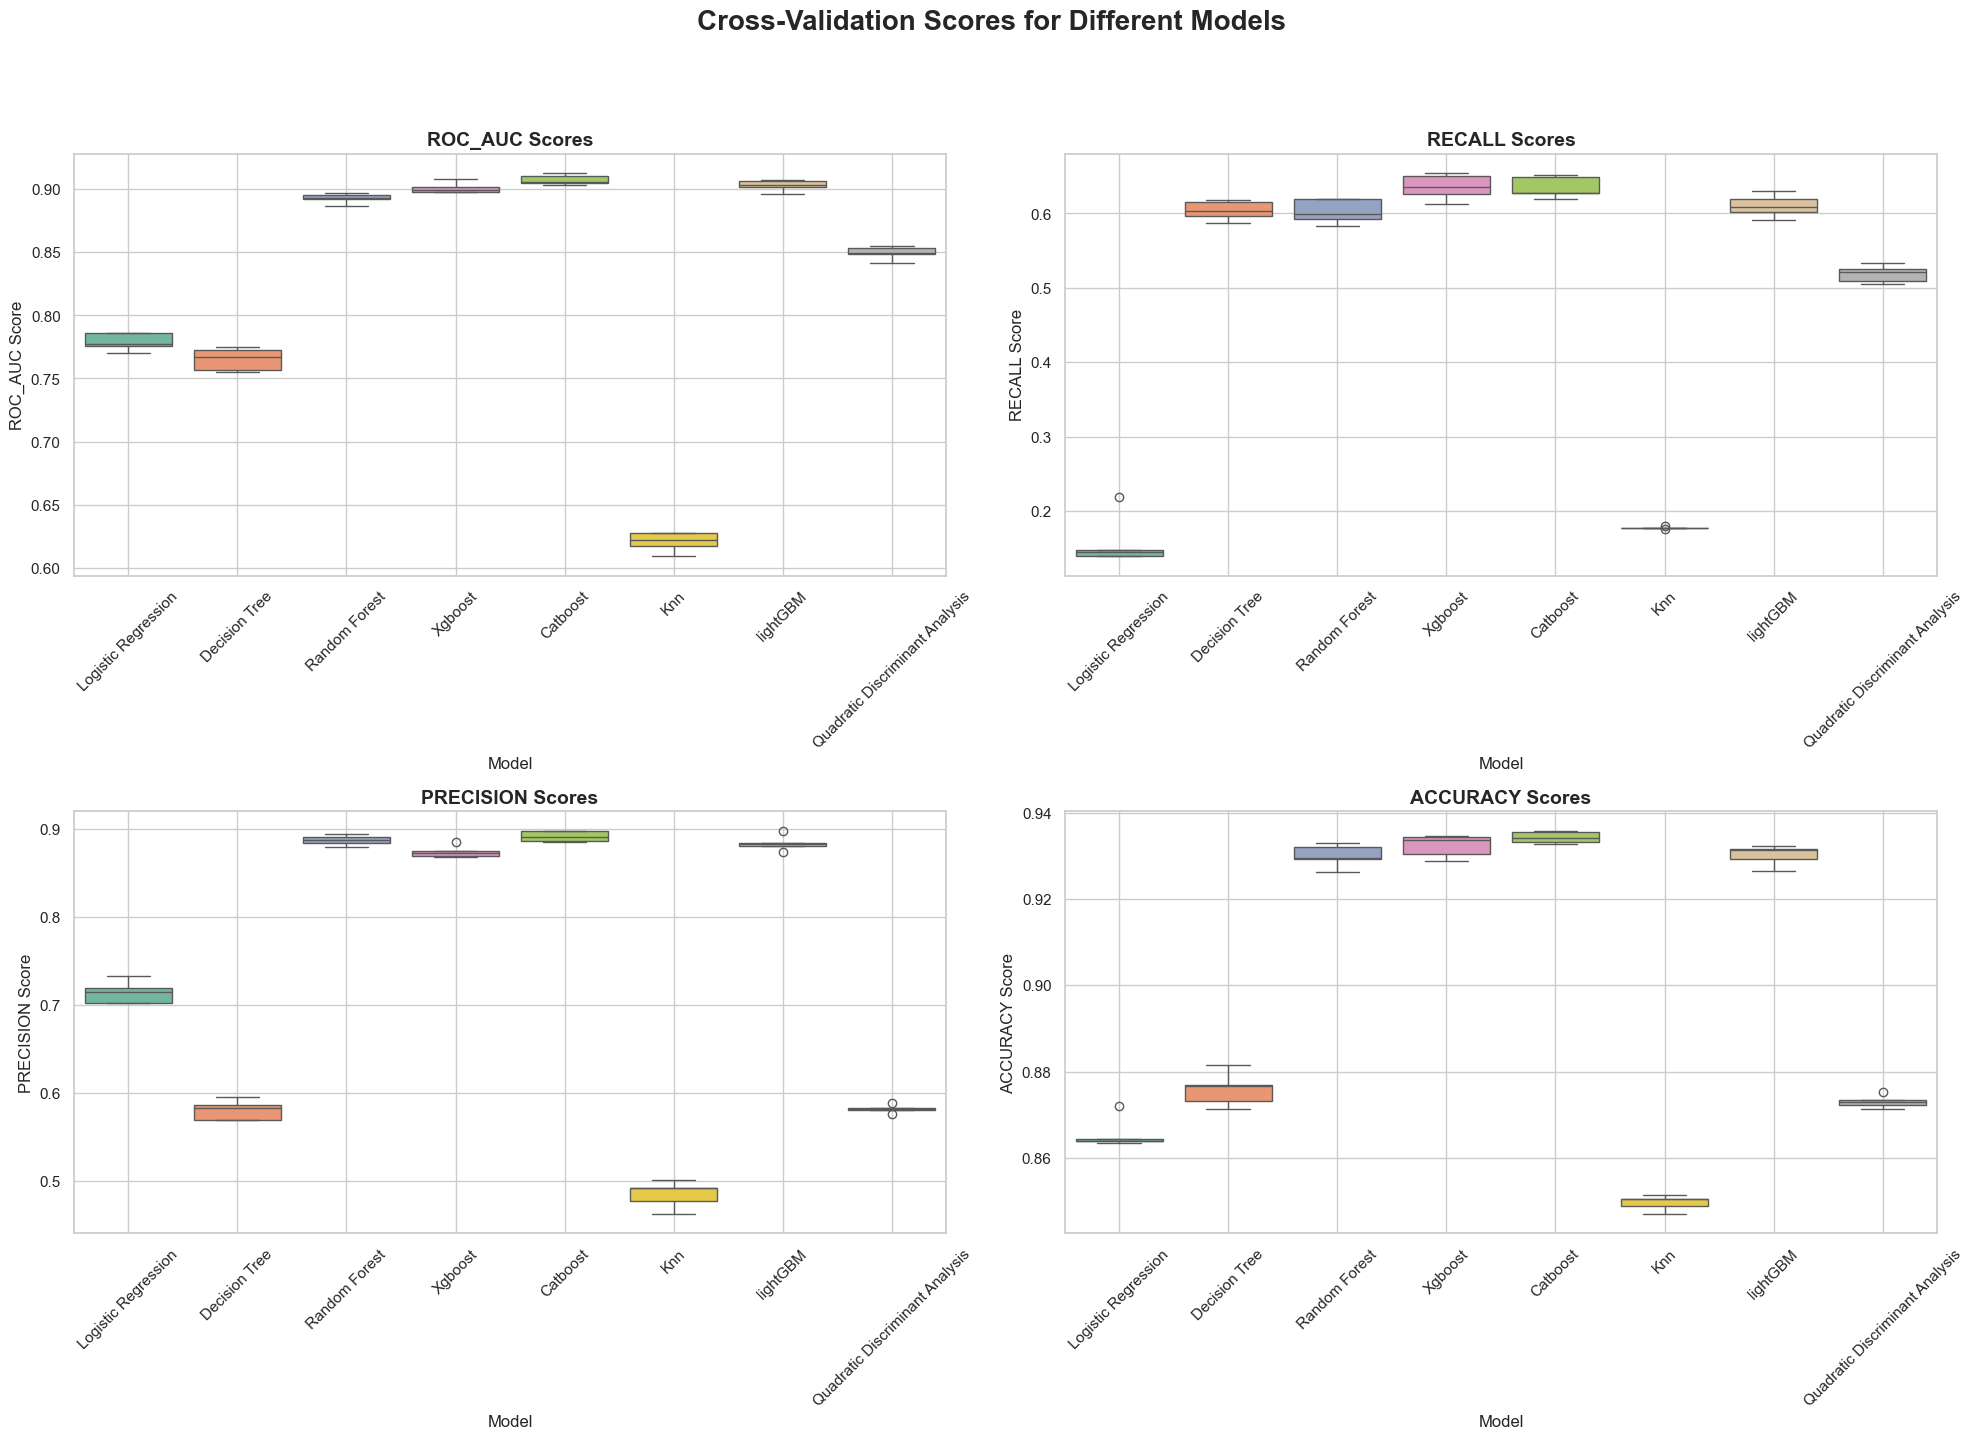

{'roc_auc': {'Logistic Regression': 0.7790640399249997,
  'Decision Tree': 0.7652353418585878,
  'Random Forest': 0.8930524334966539,
  'Xgboost': 0.9009144715703,
  'Catboost': 0.9074733169680279,
  'Knn': 0.620794783311615,
  'lightGBM': 0.9030109954428642,
  'Quadratic Discriminant Analysis': 0.8496155283589315},
 'recall': {'Logistic Regression': 0.1582417430905622,
  'Decision Tree': 0.6043061113308876,
  'Random Forest': 0.6026239548389308,
  'Xgboost': 0.6361729401961586,
  'Catboost': 0.6351643604273587,
  'Knn': 0.17758343170247373,
  'lightGBM': 0.6105281671593079,
  'Quadratic Discriminant Analysis': 0.5187076009560809},
 'precision': {'Logistic Regression': 0.7140604698749798,
  'Decision Tree': 0.5805088750122055,
  'Random Forest': 0.8873708533859321,
  'Xgboost': 0.8744719788771279,
  'Catboost': 0.8918750108002669,
  'Knn': 0.4844234661136637,
  'lightGBM': 0.8843384199089048,
  'Quadratic Discriminant Analysis': 0.5817827780773484},
 'accuracy': {'Logistic Regression':

In [ ]:

X_train = location_thresh_classification(X_train, y_train, X_train)
mean_scores, cv_results = cross_val(X_train, y_train)
mean_scores


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from lightgbm import LGBMClassifier

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fitted_models = []

def cross_val(X, y, show_plots= True):
    
    models = {
        'Logistic Regression': LogisticRegression(max_iter=100000),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Xgboost': XGBClassifier(),
        'Catboost': CatBoostClassifier(verbose= 0),
        'Knn': KNeighborsClassifier(),
        'lightGBM': LGBMClassifier()
    }
    mean_scores = {}
    cv_results = {}

    for name, model in models.items():
        cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='roc_auc');
        cv_results[name] = cv_scores
        mean_scores[name] = cv_scores.mean()
        fitted_models.append(model)

    cv_df = pd.DataFrame(cv_results)

    if show_plots == True:
        # Plotting
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=cv_df)
        plt.title('Cross-Validation ROC-AUC Scores for Different Models')
        plt.xlabel('Model')
        plt.ylabel('ROC-AUC Score')
        plt.show()
        print(mean_scores )  


    return mean_scores, cv_results  




## Chosen Algorithm: CatBoost

### Reason for Choice

After evaluating all the models, we selected **CatBoost** for the following reasons:

- **Performance**: CatBoost consistently demonstrated superior performance across multiple metrics, including accuracy, precision, recall, and ROC AUC score.
- **Handling Categorical Data**: CatBoost natively handles categorical variables, which simplifies preprocessing and improves model accuracy.
- **Overfitting Prevention**: It includes built-in mechanisms to reduce overfitting, which is particularly useful for our dataset.

### Assumptions and Limitations

#### Assumptions

- **Categorical Variables**: Assumes that categorical variables are significant predictors and can be encoded in a way that preserves their information.
- **Boosting**: Assumes that boosting weak learners sequentially can improve the model's overall performance.

#### Limitations

- **Computational Complexity**: Training CatBoost can be computationally intensive, especially with large datasets like this one.
- **Parameter Tuning**: The model requires careful tuning of hyperparameters to achieve optimal performance, which can be time-consuming.
- **Data Size**: While it handles categorical data well, very large datasets may require significant computational resources.

By thoroughly evaluating multiple algorithms and considering their assumptions and limitations, its ensured that CatBoost provides the best balance of accuracy, efficiency, and robustness for our specific predictive modeling task.


### Assess and verify the score on each fold.


In [ ]:
from numpy import interp
from sklearn.metrics import auc


def plot_roc(X, y, estimator,n_splits, lns = 100):
    #creating an instance of KFold
    kfold = StratifiedKFold(n_splits=n_splits,shuffle=False)
    #define estemator
    rf = estimator
    #deifne figuresize
    plt.rcParams['figure.figsize'] = (10,5)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,lns)
    i = 1

    for train,test in kfold.split(X,y):
        #get prediction
        prediction = rf.fit(X.iloc[train],y.iloc[train]).predict_proba(X.iloc[test])
        #get the true pos. rate, false positive rate and thresh 
        fpr, tpr, t = roc_curve(y.iloc[test], prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        #get the area under the curve
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        #plot the tpr and fpr
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1

    #plot the mean ROC
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='gold',
    label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

    #setup the labels
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title('ROC PLOT', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)

    

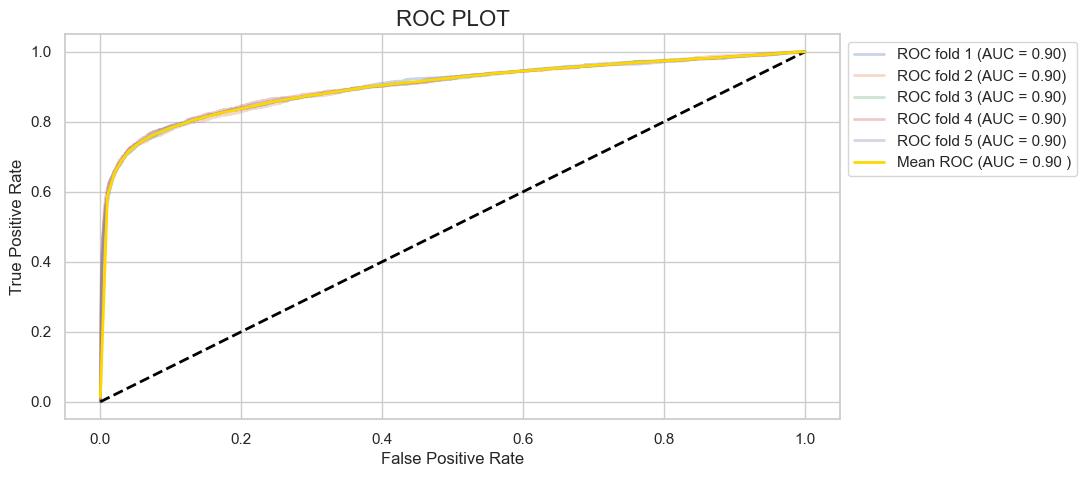

In [ ]:
plot_roc(X_train, y_train, XGBClassifier(), 5)


* The scores on individual folds are extremely close.

## **Earlier**

We identified that

1. There is a secondary distribution on loan amount from 1000 to 10000.
2. There are outliers on loan amount greater than 75000

We therefore want to train the model on that secondary distribution and the outliers and try to create ensemble models of the three models.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in

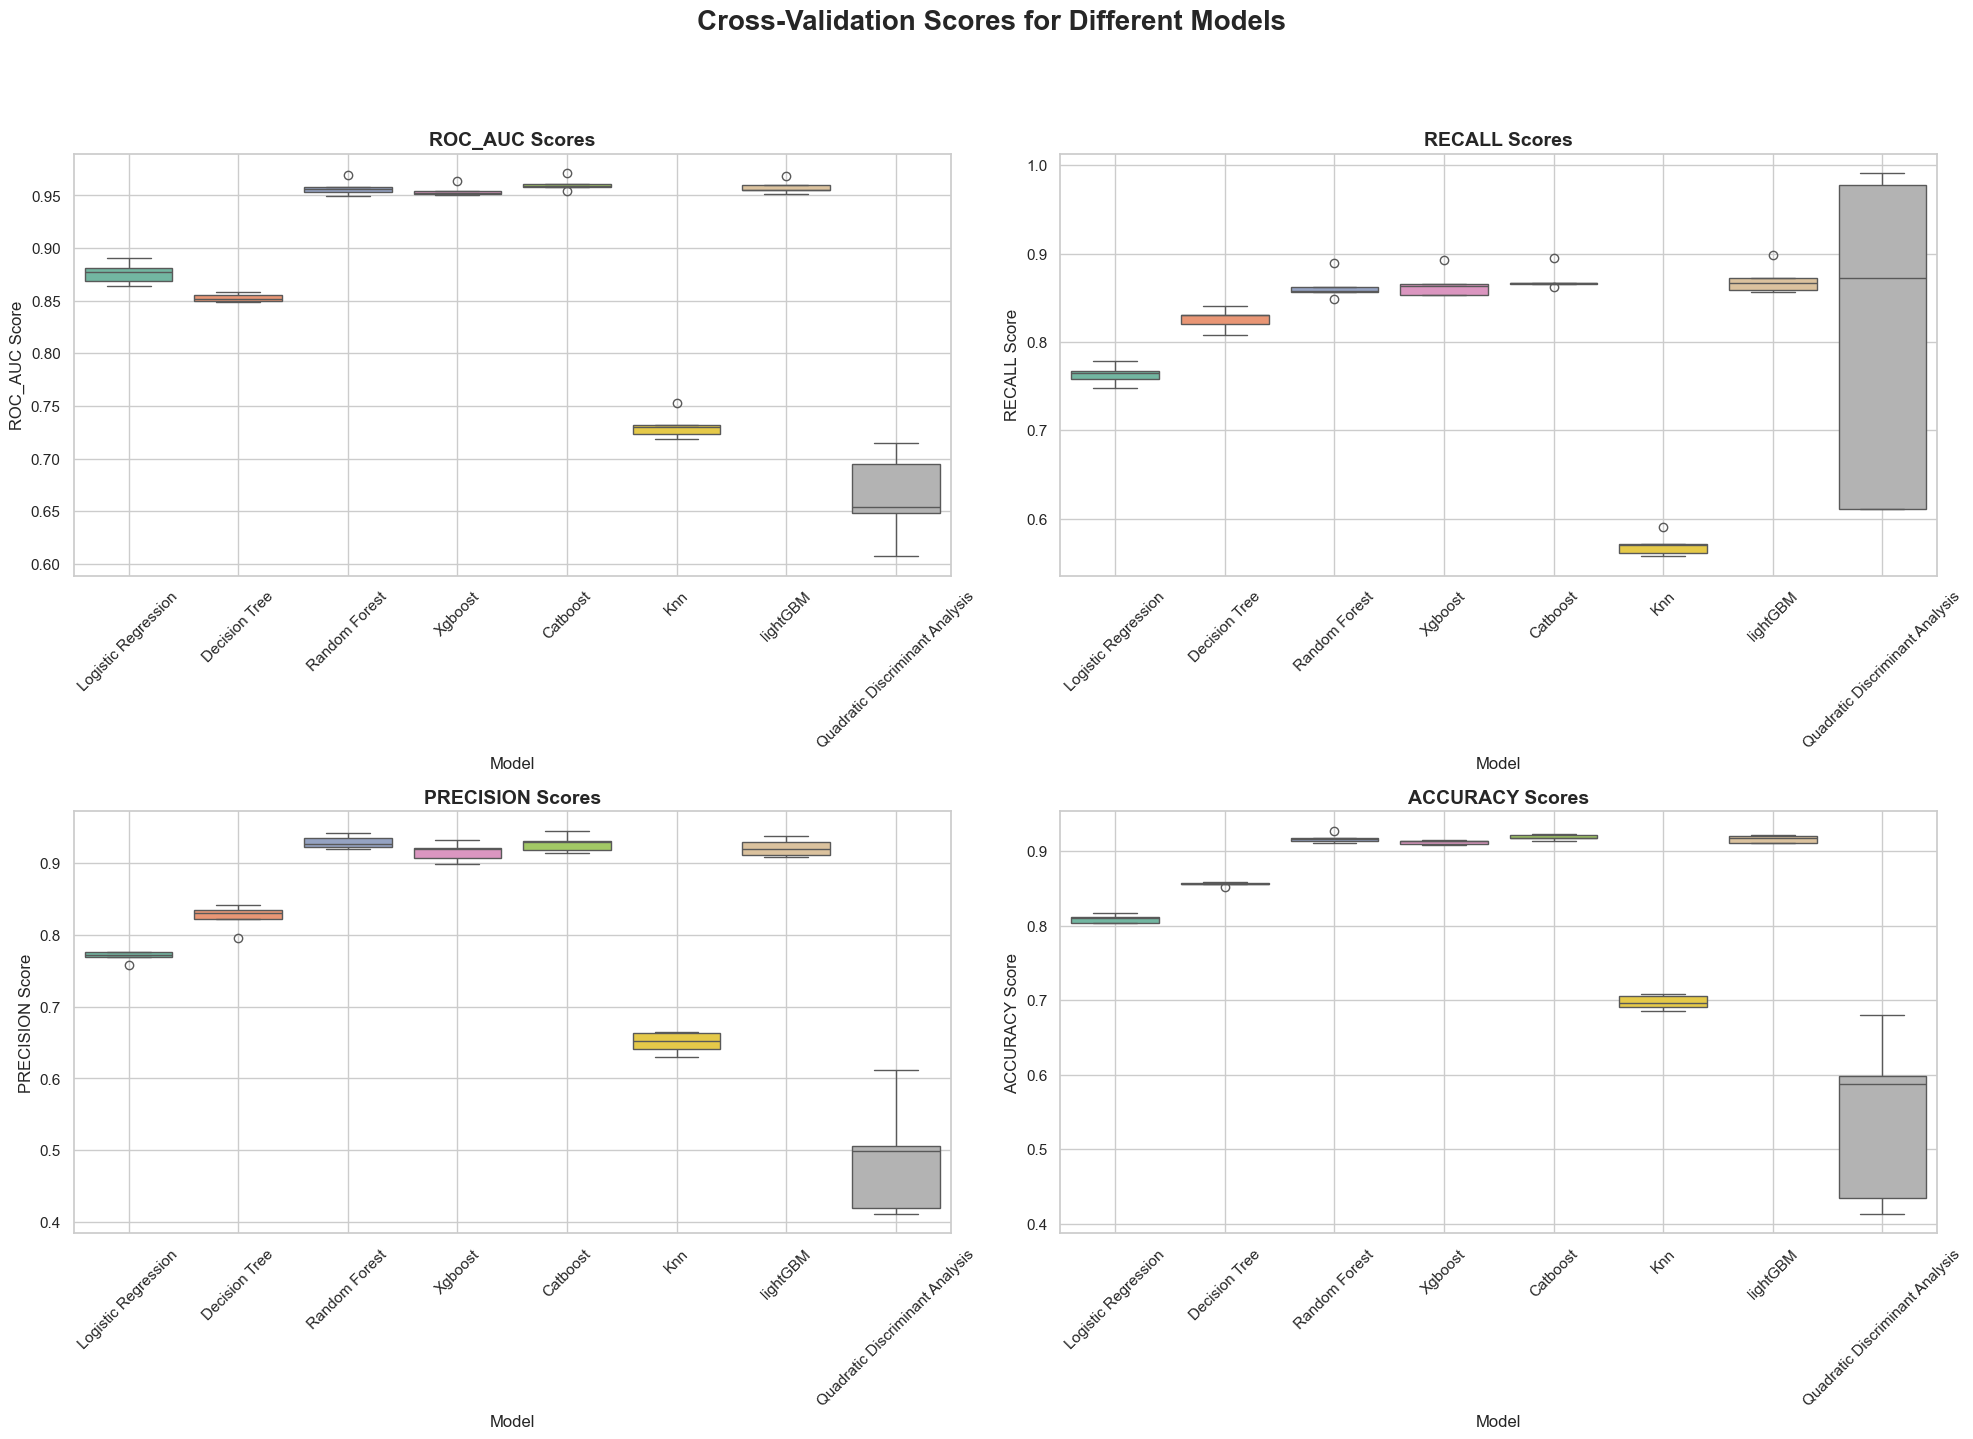

({'roc_auc': {'Logistic Regression': 0.8765014549903263,
   'Decision Tree': 0.852982282433884,
   'Random Forest': 0.9571742977279655,
   'Xgboost': 0.9542873276464539,
   'Catboost': 0.9606931798687801,
   'Knn': 0.7312090065533947,
   'lightGBM': 0.9578660485437014,
   'Quadratic Discriminant Analysis': 0.6637099625828163},
  'recall': {'Logistic Regression': 0.7631377329962769,
   'Decision Tree': 0.8260800449408657,
   'Random Forest': 0.8627319504455242,
   'Xgboost': 0.8654995189175946,
   'Catboost': 0.8710280820648894,
   'Knn': 0.5698406153073847,
   'lightGBM': 0.8703408214855586,
   'Quadratic Discriminant Analysis': 0.8127256754576259},
  'precision': {'Logistic Regression': 0.7701194544078827,
   'Decision Tree': 0.8250989368177134,
   'Random Forest': 0.9290490478334531,
   'Xgboost': 0.9158077455966765,
   'Catboost': 0.9273628126174172,
   'Knn': 0.6499941267143245,
   'lightGBM': 0.9215377144282225,
   'Quadratic Discriminant Analysis': 0.48918135269186014},
  'accura

In [ ]:
# scores for less than 10000
X_train_0_to_10000 = X_train[X_train['loan_amount']<=10000]
y_train_0_to_10000 = y_train[X_train['loan_amount']<=10000]

cross_val(X_train_0_to_10000, y_train_0_to_10000)


- There is a higher score of 0.97 with catboost having highest score


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

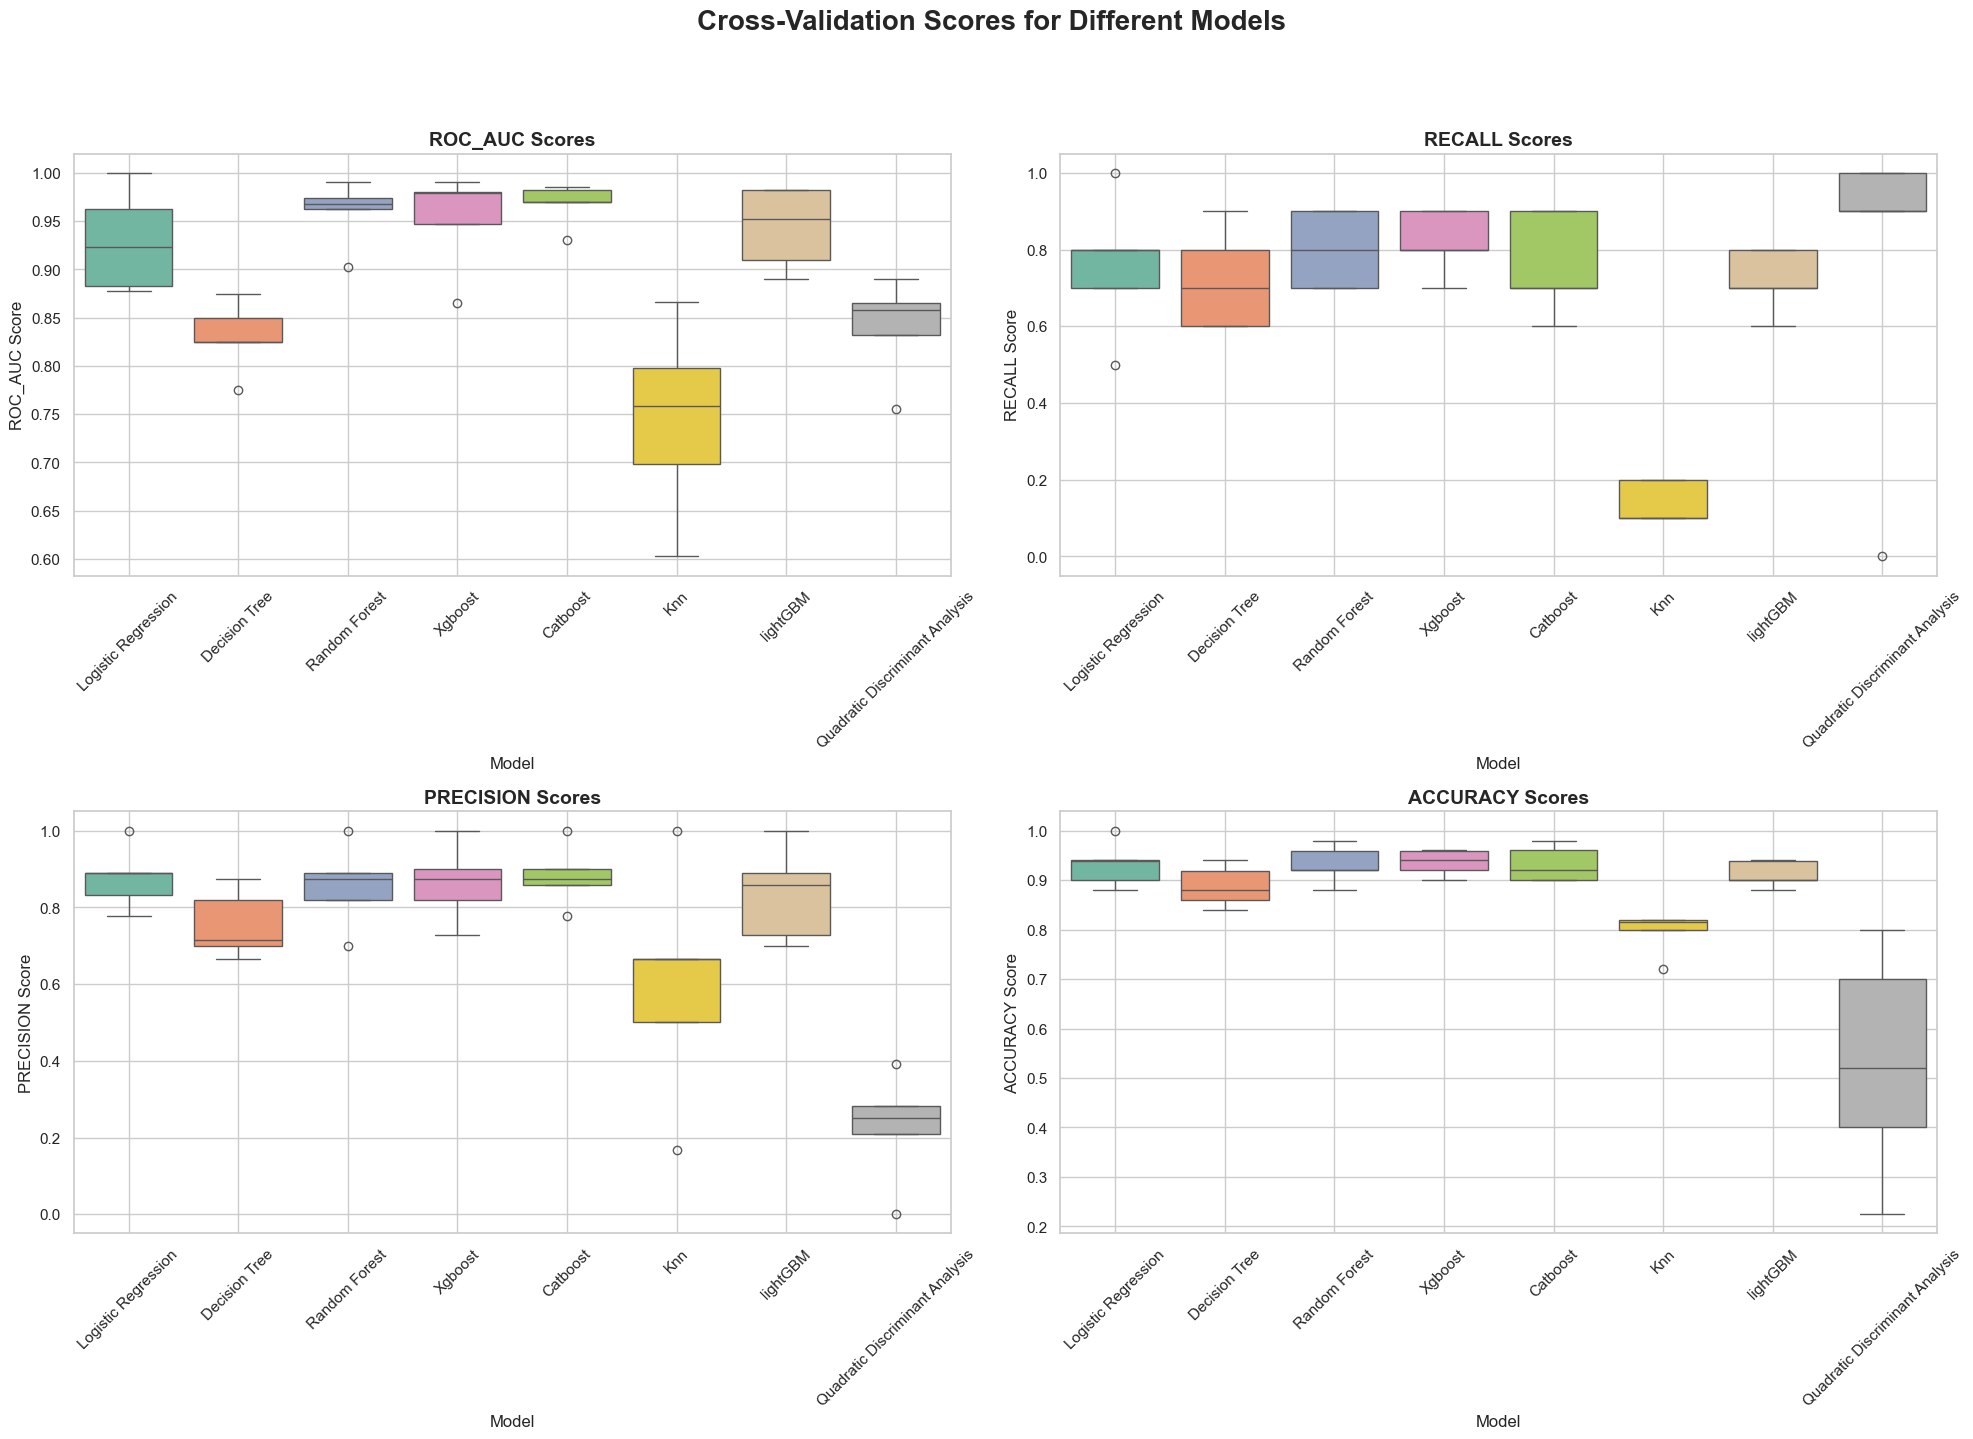

({'roc_auc': {'Logistic Regression': 0.9291153846153846,
   'Decision Tree': 0.8298717948717949,
   'Random Forest': 0.9593717948717948,
   'Xgboost': 0.9523974358974359,
   'Catboost': 0.9674102564102564,
   'Knn': 0.7447371794871794,
   'lightGBM': 0.9434102564102563,
   'Quadratic Discriminant Analysis': nan},
  'recall': {'Logistic Regression': 0.76,
   'Decision Tree': 0.72,
   'Random Forest': 0.8,
   'Xgboost': 0.82,
   'Catboost': 0.76,
   'Knn': 0.13999999999999999,
   'lightGBM': 0.72,
   'Quadratic Discriminant Analysis': 0.76},
  'precision': {'Logistic Regression': 0.8777777777777779,
   'Decision Tree': 0.7548268398268398,
   'Random Forest': 0.8564141414141414,
   'Xgboost': 0.864090909090909,
   'Catboost': 0.881984126984127,
   'Knn': 0.5999999999999999,
   'lightGBM': 0.8346608946608945,
   'Quadratic Discriminant Analysis': 0.22617753623188402},
  'accuracy': {'Logistic Regression': 0.9317551020408164,
   'Decision Tree': 0.8876734693877552,
   'Random Forest': 0.931

In [ ]:
X_train_outlier = X_train[X_train['loan_amount']>75000]
y_train_outlier = y_train[X_train['loan_amount']>75000]

cross_val(X_train_outlier, y_train_outlier)

- There is a higher score of 0.97 with catboost having highest score


# MODEL EVALUATION


### Baseline model


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# function to evaluate our model
def train_evaluate_model(X_train, y_train, X_test, y_test,model = CatBoostClassifier(learning_rate=0.070, verbose=0), threshold = 0.5,show_plots = False):
    # Initialize and train the CatBoost model
    model.fit(X_train, y_train);
    
    # Apply any additional preprocessing to the test set if needed
    X_test_processed = location_thresh_classification(X_train, y_train, X_test)
    
    # Predict on the test set
    
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
    y_pred_proba = np.where(X_test['number_of_defaults'] <1, y_pred_proba-0.015, y_pred_proba)
    y_pred_proba = np.where(X_test['interest_rate'] <=13, y_pred_proba+0.1, y_pred_proba)
    y_pred_proba = np.where(X_test['number_of_defaults'] >=2, y_pred_proba+0.025, y_pred_proba)
    y_pred = np.where(y_pred_proba>=threshold, 1,0).astype('int')
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred)
    if show_plots == True:
        auc = roc_auc_score(y_test, y_pred_proba)
        # Calculate ROC curve (fpr, tpr, thresholds)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        # fpr, tpr, thresholds = roc_curve(y_test, y_preds)
        J = tpr - fpr
        ix = np.argmax(J)
        optimal_threshold = thresholds[ix]
        print(f"Optimal Threshold (ROC): {optimal_threshold}")
        
        # Plot ROC curve
        print(auc)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label='ROC Curve (area = %0.4f)' % auc)
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()
        
        

    return {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc
    }, model,report, y_pred, y_pred_proba 



In [ ]:

base_model_metrics, model,report, y_pred, y_pred_proba= train_evaluate_model(X_train, y_train, X_test, y_test)
for metric, value in base_model_metrics.items():
    print(f"{metric}: {value}")


Accuracy: 0.93765
Precision: 0.8742411101474414
Recall: 0.6781029263370333
F1 Score: 0.7637810191324115
ROC AUC: 0.9208676526513923


### **We are going to try an ensemble model using :-**

1. points with loan amount less than 10000
2. points with loan amount greater than 75000 (outliers)
3. base model for the rest of the points


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# function to classify for different loan_amount conditions
def train_and_evaluate_models(X_train, y_train, X_test, y_test):

    # X_test = location_thresh_classification(X_train, y_train, X_test)
    X_test = X_test
    models = {
        'loan under 10000': CatBoostClassifier(verbose=0),
        'loan above 75000': CatBoostClassifier(verbose=0),
        'base_model for loan inbetween': CatBoostClassifier(verbose=0)
    }
    
    # Define conditions for training subsets
    conditions = {
        'loan under 10000': X_train['loan_amount'] < 10000,
        'loan above 75000': X_train['loan_amount'] > 75000,
        'base_model for loan inbetween': (X_train['loan_amount'] > 0) & (X_train['loan_amount'] < 1000000)
    }
    
    # Train models
    for model_name, condition in conditions.items():
        X_train_subset = X_train[condition]
        y_train_subset = y_train[condition]
        models[model_name].fit(X_train_subset, y_train_subset)

    # Define test conditions
    test_conditions = {
        'loan under 10000': X_test['loan_amount'] < 10000,
        'loan above 75000': X_test['loan_amount'] > 75000,
        'base_model for loan inbetween': (X_test['loan_amount'] >= 10000) & (X_test['loan_amount'] <= 75000)
    }
    
    # Evaluate models
    def evaluate_model(model, X, y):
        y_pred_proba = model.predict_proba(X)[:, 1]
        y_pred = model.predict(X)
        return {
            "ROC AUC": roc_auc_score(y, y_pred_proba),
            "Accuracy": accuracy_score(y, y_pred),
            "Precision": precision_score(y, y_pred),
            "Recall": recall_score(y, y_pred),
            "F1 Score": f1_score(y, y_pred),
        }

    metrics = {}
    for model_name, condition in test_conditions.items():
        X_test_subset = X_test[condition]
        y_test_subset = y_test[condition]
        metrics[model_name] = evaluate_model(models[model_name], X_test_subset, y_test_subset)

    return models, metrics


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

#function to create ensemble model
def ensemble_model(models, X_test, y_test):
    # Initialize the prediction probabilities array
    y_pred_proba = np.zeros_like(y_test, dtype=float)
    y_pred = np.zeros_like(y_test, dtype=int)

    # Create masks based on loan_amount conditions
    mask0 = X_test['loan_amount'] < 10000
    mask1 = X_test['loan_amount'] > 75000
    mask2 = (~(mask0 | mask1))

    # Predict probabilities for different conditions
    y_pred_proba[mask0] = models['loan under 10000'].predict_proba(X_test[mask0])[:, 1]
    y_pred[mask0] = models['loan under 10000'].predict(X_test[mask0])

    y_pred_proba[mask1] = models['loan above 75000'].predict_proba(X_test[mask1])[:, 1]
    y_pred[mask1] = models['loan above 75000'].predict(X_test[mask1])

    y_pred_proba[mask2] = models['base_model for loan inbetween'].predict_proba(X_test[mask2])[:, 1]
    y_pred[mask2] = models['base_model for loan inbetween'].predict(X_test[mask2])

    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return {
        "ROC AUC": roc_auc,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
    }




In [ ]:
# compare base and ensemble model
models, metrics = train_and_evaluate_models(X_train, y_train, X_test, y_test)
ensemble_metrics = ensemble_model(models, X_test, y_test)
# Print ensemble metrics
print("Ensemble Model Metrics:")
print()
for metric, value in ensemble_metrics.items():
    print(f"{metric}: {value}")

Ensemble Model Metrics:

ROC AUC: 0.9177545344525231
Accuracy: 0.93795
Precision: 0.9115969581749049
Recall: 0.6451395896400942
F1 Score: 0.7555643096316722


### **Compare the base and ensemble models**


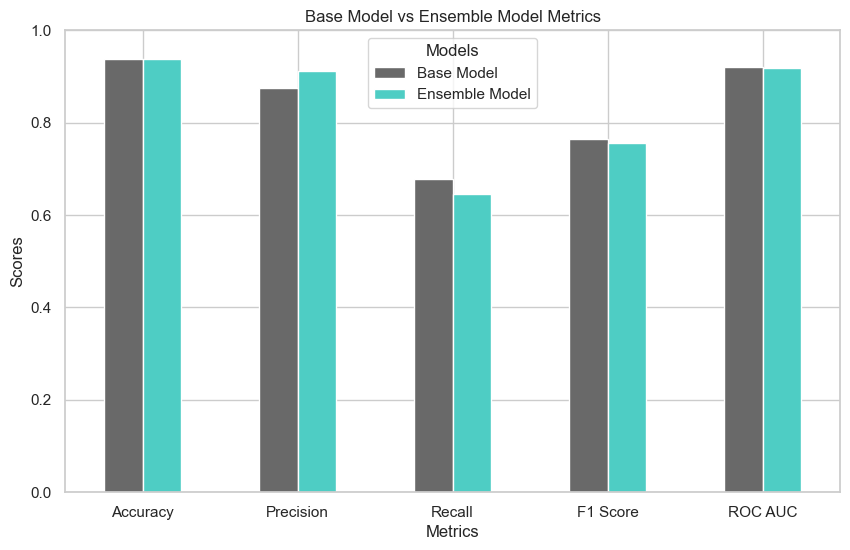

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def compare_models(base_model_metrics, ensemble_metrics):
    # Convert the metrics dictionaries to pandas DataFrames
    metrics_df = pd.DataFrame({'Base Model': base_model_metrics, 'Ensemble Model': ensemble_metrics})

    # Plot the metrics
    metrics_df.plot.bar(figsize=(10, 6), color=['#696969', '#4ecdc4'], rot=0)


    # Set plot labels and title
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Base Model vs Ensemble Model Metrics')
    plt.ylim(0, 1)  # Set y-axis limit for better comparison
    plt.legend(title='Models')

    # Show the plot
    plt.show()
compare_models(base_model_metrics, ensemble_metrics)    


- The `ensemble model` is literally the same as the `base model`
- To avoid complexities, we stick to the simple `base model`.


# MODEL BIAS ANALYSIS

## **Feature Importance**


Here we are going to assess the importances of individual features using our models builtin feature importances feature.

In [ ]:
_, model, __, y_pred,y_pred_proba = train_evaluate_model(X_train, y_train, X_test, y_test)
feature_importances = pd.DataFrame(model.feature_importances_).T
feature_importances.columns = model.feature_names_
feature_importances.T.sort_values(by=0, ascending=False)

,0
age,13.016914
location,11.836190
interest_rate,11.036923
loan_amount,10.664032
total_loan_amount_per_job,10.344425
location_class,8.990857
salary,5.675553
remaining term,5.434454
job,4.315608
job_location_interact,3.980637


### Feature Importances Overview

- **High Impact Features:**
  - `age`
  - `total_loan_amount_per_job`
  - `interest_rate`
  - `loan_amount`
  - `location`

- **Moderate Impact Features:**
  - `salary`
  - `remaining term`
  - `job_location_interact`
  - `location_class`
  - `job`
  - `Category`
  - `marital_status`

- **Lower Impact Features:**
  - `outstanding_balance`
  - `number_of_defaults`
  - `gender`
  - `is_employed`

- **Minimal Impact Features:**
  - `loan_equal_5000`
  - `loan_>_75000`

This overview shows how various features contribute to the model's performance, with some features having a significantly higher impact than others.


## Confusion matrix
We want to identify classes our model is failing misearably.

<Figure size 1000x500 with 0 Axes>

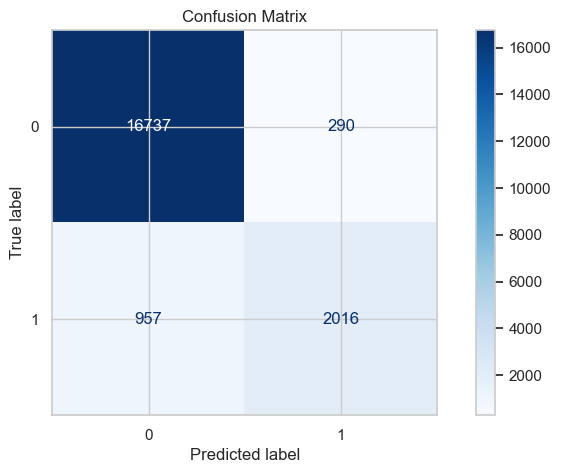

In [ ]:
# Plot confusion 
plt.figure();
cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(confusion_matrix=cm);
disp.plot(cmap=plt.cm.Blues);
plt.title('Confusion Matrix');
plt.show();


### Confusion Matrix Interpretation

- **High True Negatives (TN = 16737):** The model performs very well at correctly identifying non-defaulted loans.
- **High True Positives (TP = 2016):** The model is also quite good at correctly identifying defaulted loans.
- **False Positives (FP = 290):** There are relatively few false positives, indicating that the model doesn't often incorrectly identify non-defaulted loans as defaulted.
- **False Negatives (FN = 957):** There is a moderate number of false negatives, meaning the model sometimes misses defaulted loans.

### Findings

Overall, the model demonstrates high accuracy and specificity, meaning it is very good at correctly identifying non-defaulted loans. The precision is also quite high, indicating that when the model predicts a loan will default, it is usually correct. However, the recall is lower, suggesting that the model misses a significant number of defaulted loans. This trade-off between precision and recall is typical in many classification problems, and depending on the application


### ROC AUC Analysis by Sensitive Features

#### Objective:
This code snippet is designed to analyze the performance of a machine learning model based on ROC AUC scores across various sensitive features. The goal is to understand how well the model predicts loan default status across different subgroups defined by these features and identify bias.

#### Key Steps:
1. **Data Preparation:**
   - The test data (`X_test`) is prepared by binning numerical features and mapping categorical features using predefined label encodings. This ensures consistency in data representation for analysis.

2. **Results Compilation:**
   - A results DataFrame (`results_df`) is created to store:
     - Actual loan default labels (`Actual`).
     - Predicted probabilities of default (`y_pred_proba`).
     - Sensitive features such as `gender`, `location`, `job`, `marital_status`, and numeric features like `loan_amount`, `salary`, `outstanding_balance`, etc.

3. **ROC AUC Analysis:**
   - ROC AUC scores are computed for each subgroup defined by the sensitive features. This metric measures the model's ability to distinguish between default and non-default cases within each subgroup.
   
4. **Visualization:**
   - The ROC AUC scores are visualized using bar plots for each sensitive feature. Each plot shows how well the model performs across different subgroups, helping identify which features have a significant impact on prediction accuracy.

#### Meaning:
- Higher ROC AUC scores indicate better model performance within a subgroup, suggesting the model's effectiveness in predicting loan default status for that particular segment of data.
- Lower ROC AUC scores may highlight areas where the model performs less accurately, signaling potential biases or areas needing improvement in predictive capability.



feature: gender

category: female roc_auc: 0.926056437379958
category: male roc_auc: 0.9171262134826458
category: other roc_auc: 0.9185736719215092
feature: location

category: Beitbridge roc_auc: 0.9449523609359675
category: Bulawayo roc_auc: 0.9625979505726342
category: Chimanimani roc_auc: 0.9414750380386415
category: Chipinge roc_auc: 0.9371448525443637
category: Chiredzi roc_auc: 0.9163928837093975
category: Chivhu roc_auc: 0.9400352733686066
category: Gokwe roc_auc: 0.8996515679442508
category: Gweru roc_auc: 0.9547806524184477
category: Harare roc_auc: 0.8764224228427462
category: Hwange roc_auc: 0.8153846153846154
category: Kadoma roc_auc: 0.8908747573073753
category: Kariba roc_auc: 0.8614718614718615
category: Karoi roc_auc: 0.8397798481185268
category: Kwekwe roc_auc: 0.8546921142427816
category: Marondera roc_auc: 0.3
category: Masvingo roc_auc: 0.7993640443309449
category: Mutare roc_auc: 0.8482523576830902
category: Nyanga roc_auc: 0.7893864013266999
category: Plumtree ro

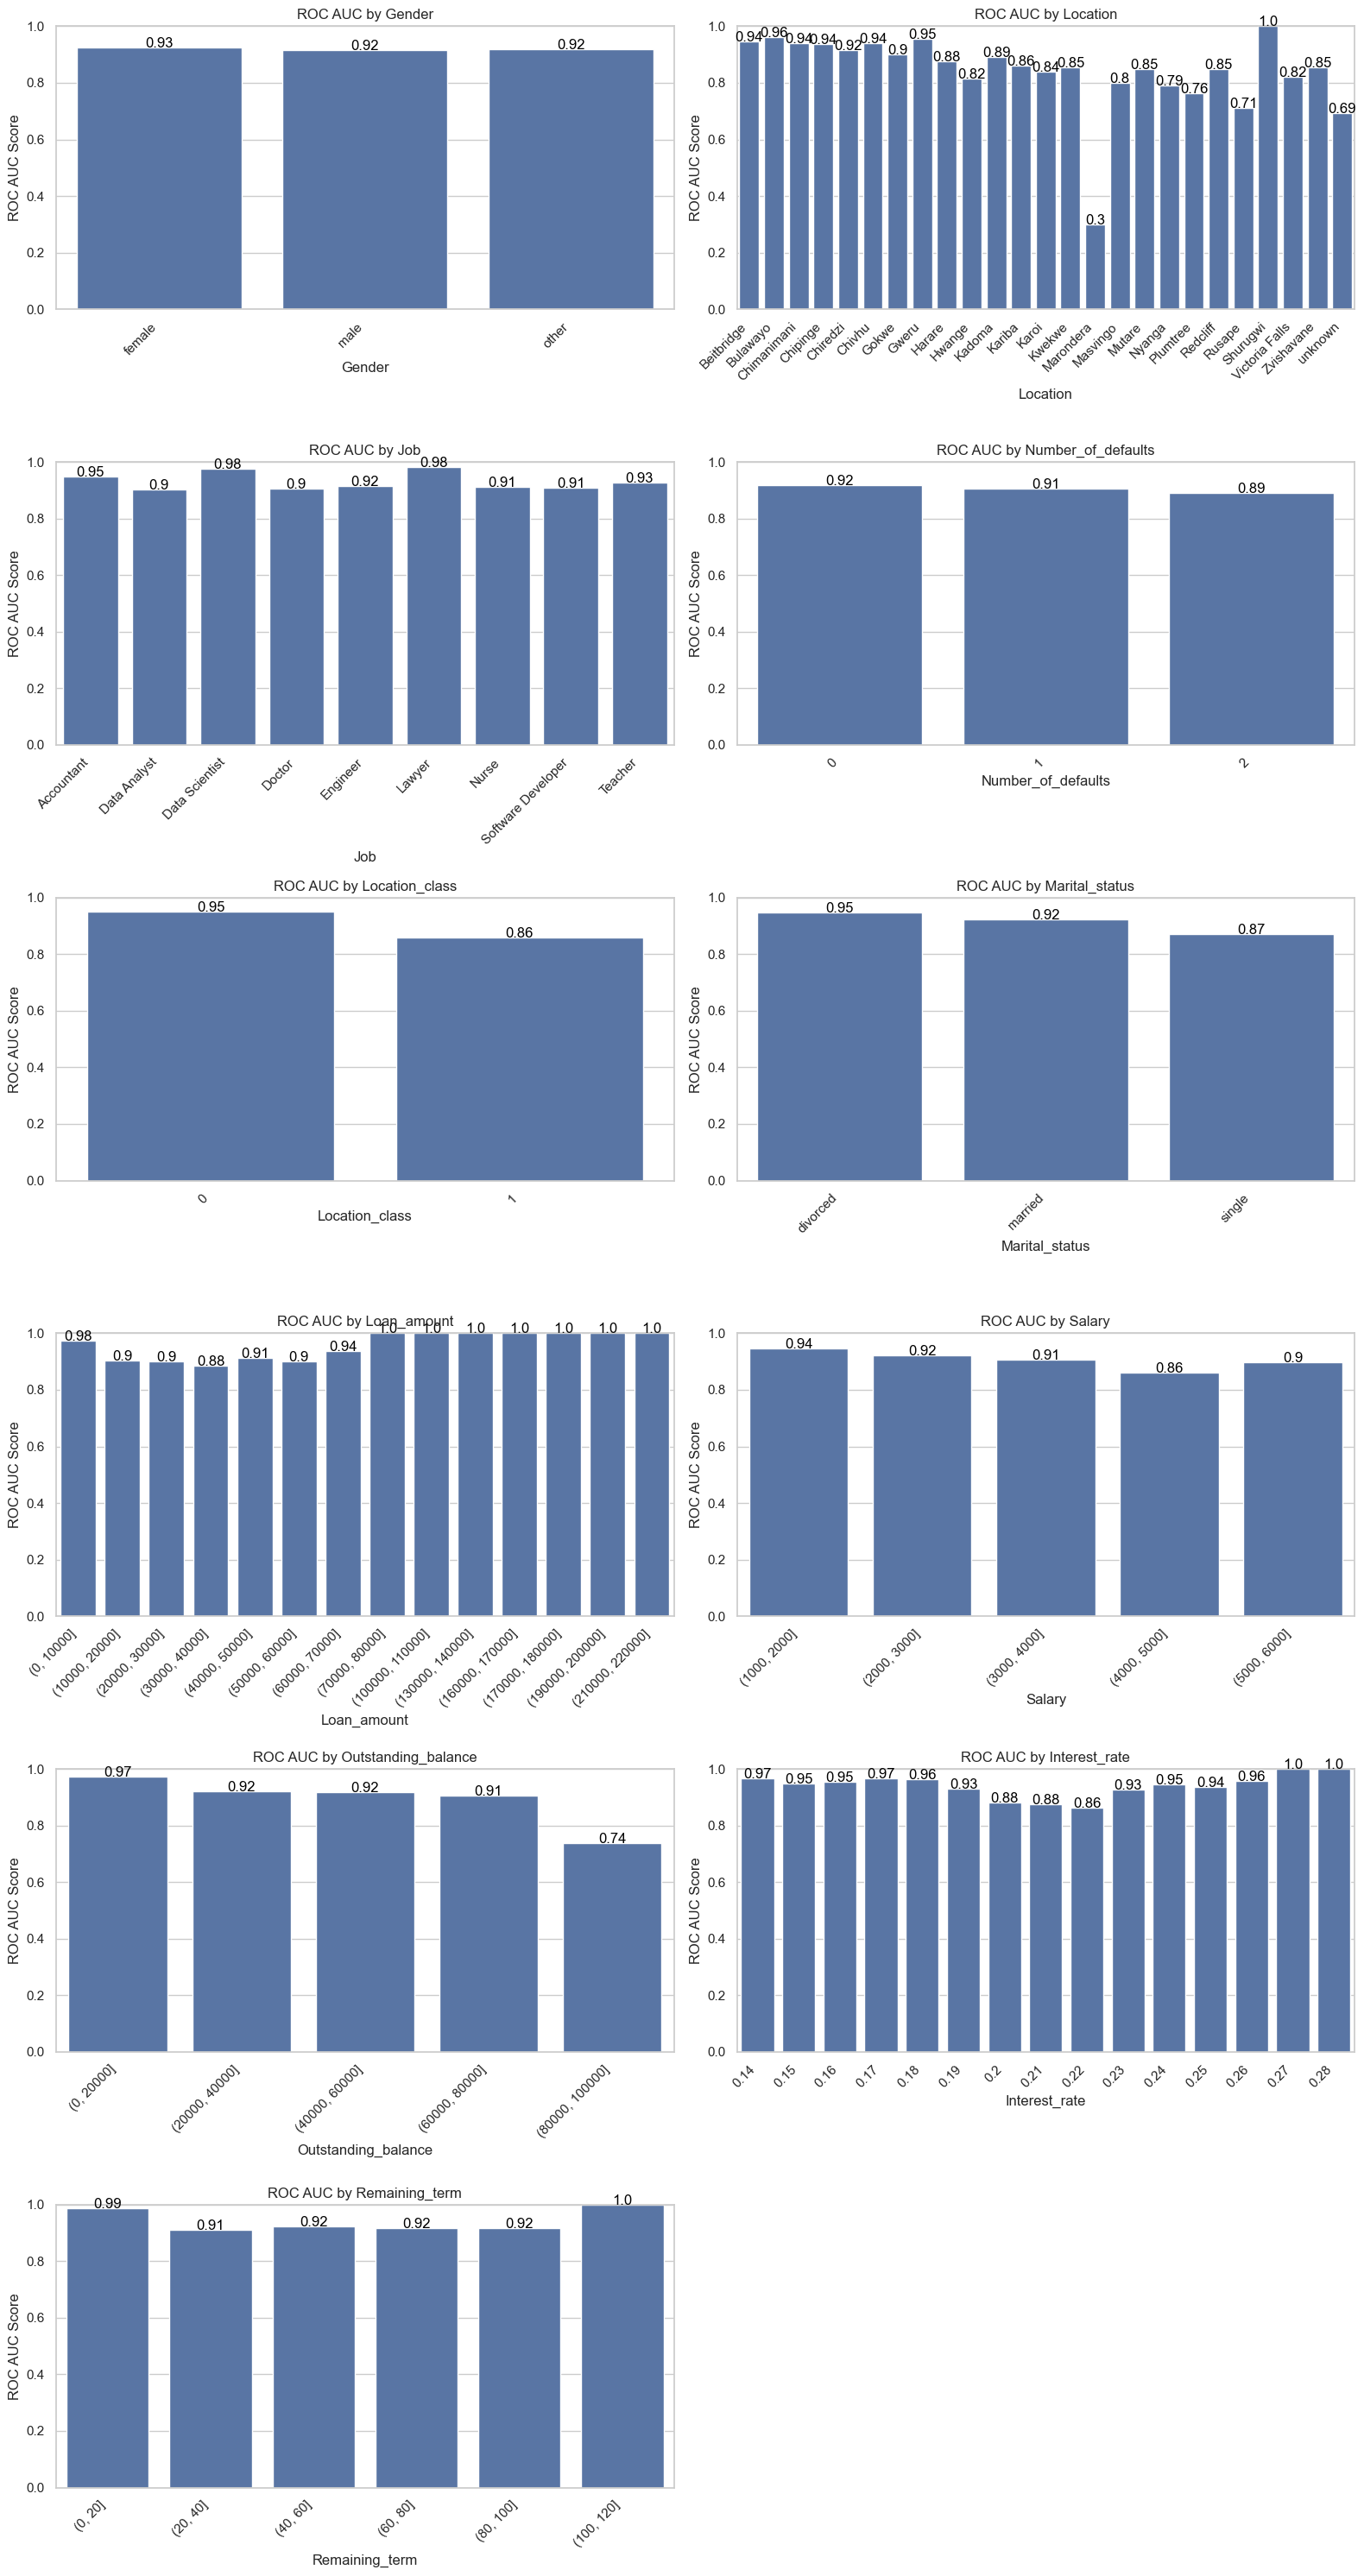

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

def plot_roc_auc_by_feature(results_df, sensitive_features):
    """
    Plot ROC AUC scores by different sensitive features.

    Parameters:
    - results_df (pd.DataFrame): DataFrame containing actual values, predicted probabilities, and features.
    - sensitive_features (list of str): List of features to analyze.
    """
    n_features = len(sensitive_features)
    fig, axes = plt.subplots(nrows=(n_features + 1) // 2, ncols=2, figsize=(16, 30))
    axes = axes.flatten()

    for i, feature in enumerate(sensitive_features):
        subgroups = results_df.groupby(feature, observed=True)
        roc_auc_scores = []
        print(f'feature: {feature}')
        print()
        for name, group in subgroups:
            if len(group['Actual'].unique()) <= 1:
                print(f'{name} of {feature} has 1 class of y')
                continue
            roc_auc = roc_auc_score(group['Actual'], group['y_pred_proba'])
            roc_auc_scores.append((name, roc_auc))
            print(f'category: {name} roc_auc: {roc_auc}')
            

        print('===========================================')

            
            

        roc_auc_df = pd.DataFrame(roc_auc_scores, columns=[feature, 'ROC AUC'])
        sns.barplot(data=roc_auc_df, x=feature, y='ROC AUC', ax=axes[i])
        axes[i].set_title(f'ROC AUC by {feature.capitalize()}')
        axes[i].set_ylim(0, 1)
        axes[i].set_xlabel(feature.capitalize())
        axes[i].set_ylabel('ROC AUC Score')
        for label in axes[i].get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')

        # Add text annotations for each bar
        for index, row in roc_auc_df.iterrows():
            axes[i].text(row.name, row['ROC AUC'], round(row['ROC AUC'], 2), color='black', ha="center")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Example usage
label_encodings_location = {v: k for k, v in label_encodings['location'].items()}
label_encodings_job = {v: k for k, v in label_encodings['job'].items()}

X_test_plot = X_test.copy()
X_test_plot['loan_amount'] = pd.cut(X_test_plot['loan_amount'], bins=np.arange(0, 300000, 10000))
X_test_plot['salary'] = pd.cut(X_test_plot['salary'], bins=np.arange(0, 10000, 1000))
X_test_plot['outstanding_balance'] = pd.cut(X_test_plot['outstanding_balance'], bins=np.arange(0, 300000, 20000))
X_test_plot['remaining_term'] = pd.cut(X_test_plot['remaining term'], bins=np.arange(0, 150, 20))
X_test_plot['age'] = pd.cut(X_test_plot['age'], bins=np.arange(0, 80, 10))
X_test_plot['location'] = X_test_plot['location'].map(label_encodings_location)
X_test_plot['job'] = X_test_plot['job'].map(ind_to_feature_job).astype('int').map(label_encodings_job)
X_test_plot['marital_status'] = X_test_plot['marital_status'].map({0: 'single', 1: 'married', 2: 'divorced'})
X_test_plot['gender'] = X_test_plot['gender'].map({1: "other", 0: "female", 2: 'male'})

results_df = pd.DataFrame({
    'Actual': y_test,
    'y_pred_proba': y_pred_proba,
    'gender': X_test_plot['gender'],
    'location': X_test_plot['location'],
    'job': X_test_plot['job'],
    'number_of_defaults': X_test_plot['number_of_defaults'],
    'location_class': X_test_plot['location_class'],
    'marital_status': X_test_plot['marital_status'],
    'loan_amount': X_test_plot['loan_amount'],
    'salary': X_test_plot['salary'],
    'outstanding_balance': X_test_plot['outstanding_balance'],
    'interest_rate': X_test_plot['interest_rate'],
    'remaining_term': X_test_plot['remaining_term'],
})

sensitive_features = ['gender', 'location', 'job', 'number_of_defaults', 'location_class',
                      'marital_status', 'loan_amount', 'salary', 'outstanding_balance', 'interest_rate', 'remaining_term']

plot_roc_auc_by_feature(results_df, sensitive_features)




### Summary of ROC AUC Scores by Feature Categories

#### Gender
- **Female**: ROC AUC = 0.926
- **Male**: ROC AUC = 0.917
- **Other**: ROC AUC = 0.919

* **Location** *(Biased)*
    - Hwange (ROC AUC = 0.815) is significantly lower than other locations (e.g., Gokwe: 0.900, Karoi: 0.840).

* **Job** *(No Bias)*
    - All job categories show comparable ROC AUC scores (e.g., Lawyer: 0.983, Data Scientist: 0.977).

* **Number of Defaults** *(No Bias)*
    - ROC AUC scores for different default counts are within a similar range (e.g., 0 defaults: 0.917, 1 default: 0.907).

* **Location Class** *(No Bias)*
    - ROC AUC scores for location classes (e.g., Class 0: 0.951, Class 1: 0.859) show reasonable performance without significant bias.

* **Marital Status** *(No Bias)*
    - ROC AUC scores for marital statuses (e.g., Divorced: 0.949, Single: 0.871) exhibit consistent performance across categories.

* **Loan Amount** *(Biased)*
    - Extremely high ROC AUC scores in certain loan amount ranges (e.g., (70000, 80000]: 1.0, (100000, 110000]: 1.0), possibly indicating bias due to class imbalance.

* **Salary** *(No Bias)*
    - ROC AUC scores for salary ranges (e.g., (1000, 2000]: 0.945, (3000, 4000]: 0.908) show consistent predictive performance.

* **Outstanding Balance** *(No Bias)*
    - ROC AUC scores for outstanding balance categories (e.g., (0, 20000]: 0.968, (80000, 100000]: 0.747) are mostly consistent with some variation.

* **Interest Rate** *(No Bias)*
    - ROC AUC scores for interest rates (e.g., 0.14: 0.950, 0.27: 1.0) demonstrate consistent performance with no significant biases.

* **Remaining Term** *(No Bias)*
    - ROC AUC scores for remaining term categories (e.g., (0, 20]: 0.983, (100, 120]: 1.0) show consistent predictive ability without biases.


## BIAS MITIGATION
Here we want to try and find ways to mitigate the observed bias. We are going to try
- Feature Engineering.
- Data resampling to yield class balance.

### Secondary Feature Engineering


As have we seen that age, interest_rate, loan_amount, location, total_loan_amount_per_location have high importances, we are going to create new features on them.



Optimal Threshold (ROC): 0.2633834634169782
0.9219036400725694


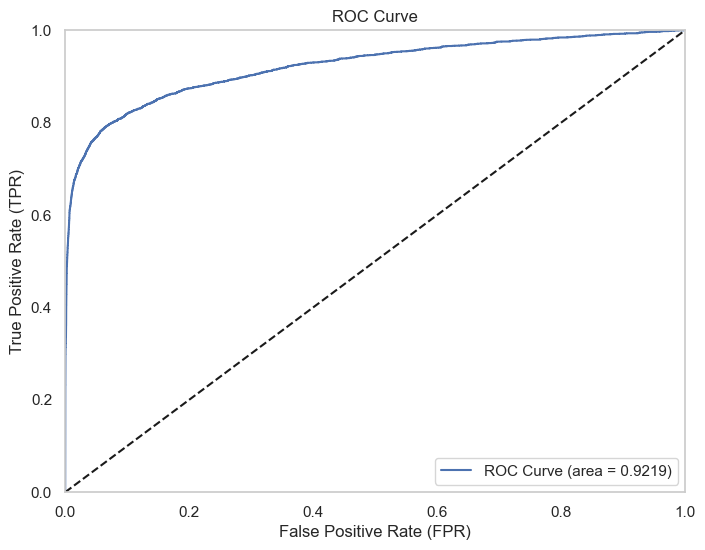

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Function to create new features
def create_new_features(df):
    epsilon = 1e-8  # Small value to avoid division by zero
    df = df.copy()  # To avoid modifying the original DataFrame
    df['interest_rate_per_loan_amount'] = df['interest_rate'] / (df['total_loan_amount_per_job'] + epsilon)
    df['age_per_loan_amount'] = df['age'] / (df['total_loan_amount_per_job'] + epsilon)
    df['job_location_per_loan_amount'] = df['job_location_interact'] / (df['total_loan_amount_per_job'] + epsilon)
    df['loan_5000_and_loan_75000_interaction'] = df['loan_equal_5000'] * df['loan_>_75000']
    
    return df

# Create new features for training and test sets
X_train_1 = create_new_features(X_train)
X_test_1 = create_new_features(X_test)


_,model,__, ___,____ = train_evaluate_model(X_train_1, y_train, X_test_1, y_test, show_plots=True)


* Our score improved a little bit

## Try resampling to balance classes

### Choice of sampling technique

#### **UNDERSAMPLING**

The chosen `undersampling` technique is **Tomek Links**, which is an under-sampling method designed to clarify the decision boundary between classes in imbalanced datasets. Tomek Links identify pairs of samples (one from each class) that are nearest neighbors to each other but belong to different classes.

- It selectively removes samples near the decision boundary to improve class separation.
- Effective for datasets where classes are densely packed or overlap.

#### **OVERSAMPLING**

The chosen `oversampling` technique is **SMOTE (Synthetic Minority Over-sampling Technique)**, which generates synthetic samples for the minority class based on the characteristics of existing minority samples.

- It creates synthetic instances along the line segments joining minority class nearest neighbors, effectively increasing the representation of the minority class.
- Suitable for addressing class imbalance by providing more diverse and representative training data for models.


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# over_sampling with tomeklinks
tl = TomekLinks()
X_tl, y_tl = tl.fit_resample(X_train_1, y_train)
tomek_link_scores, model, __,___,____= train_evaluate_model(X_tl,y_tl, X_test_1, y_test)
print('tomeklink scores')
print()
print(tomek_link_scores)
print('=====================================')

sm = SMOTE(sampling_strategy='auto')
X_smote, y_smote = tl.fit_resample(X_train_1, y_train)

smote_scores, model, __ ,___, ____= train_evaluate_model(X_smote,y_smote, X_test_1, y_test)
print('smote scores')
print('=====================================')
print(smote_scores)


tomeklink scores

{'Accuracy': 0.91745, 'Precision': 0.7259056732740943, 'Recall': 0.7144298688193743, 'F1 Score': 0.7201220545855229, 'ROC AUC': 0.9144701443786347}
smote scores
{'Accuracy': 0.91745, 'Precision': 0.7259056732740943, 'Recall': 0.7144298688193743, 'F1 Score': 0.7201220545855229, 'ROC AUC': 0.9144701443786347}


### CLUSTERING
#### APPLYING ELBOW METHOD TO FIND THE BEST NUMBER OF CLUSTERS

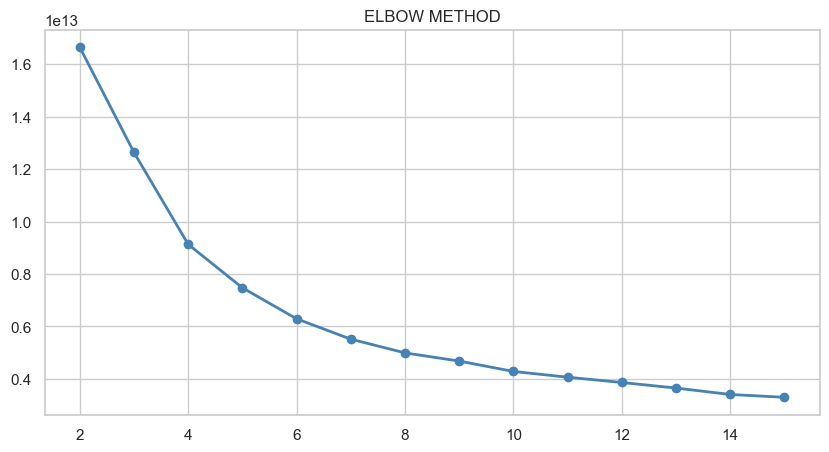

In [ ]:
inertias = []

for i in range(2,16):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X_train)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.title('ELBOW METHOD')
plt.plot(np.arange(2,16),inertias, marker='o', lw=2, color='steelblue');

* K = 8 seems more as the elbow. Try K = 8 and around


In [ ]:
## APPLYING K-MEANS TO THE DATASET 


kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train)
X_train_1['cluster'] = kmeans.labels_
X_test_1['cluster'] = kmeans.predict(X_test)

_,model,__, ___,____ = train_evaluate_model(X_train_1, y_train, X_test_1, y_test, show_plots=True)



ValueError: could not convert string to float: 'other'

* **Model improved by 0.001**

### **SAMPLING FINDINGS**

Like most sampling techniques with boosting algorithms. Both undersampling(tomek) and oversampling(smote) did not improve our model. Therefore we will stick to our base model.


### Explanation of Model Predictions

The model performs well overall, with high ROC AUC scores and no significant bias for features like gender, job, and salary. However, there is noticeable bias in the location and loan amount features, with extreme ROC AUC scores in some categories suggesting potential class imbalance issues.



### Model Limitations

The model has several limitations that should be considered:

* **Location Bias:**  Performance is notably weaker in Hwange.
* **Loan Amount Bias:** Potential bias exists for specific loan amounts.
* **Class Imbalance:** The dataset's extreme imbalance may affect the model's ability to predict defaults accurately for smaller loan amounts.
* **Generalization:**  The model's accuracy may not generalize well to data significantly different from the training data.


### Potential enhancements or future directions for model improvement.

* **Address Bias:**
    * Gather more data from Hwange or develop specialized models for this location.
    * Explore resampling techniques (e.g., SMOTE) or cost-sensitive learning to mitigate loan amount bias.
* **Feature Engineering:**  Create new features or transform existing ones to capture more predictive information.
* **Hyperparameter Tuning:** Fine-tune CatBoost's parameters for optimal performance.
* **Alternative Models:** Experiment with other algorithms like XGBoost or LightGBM.


### Business Implications

The findings have significant implications for the business:

**Fairness and Risk Management:**  Addressing potential biases is crucial to ensure fair treatment of borrowers and mitigate financial risks.
* **Targeted Interventions:** Develop tailored loan products or interventions for specific customer segments, such as those in Hwange.
* **Model Monitoring:** Continuous monitoring and retraining are essential to maintain the model's accuracy and fairness over time.

# DATA DRIFT 

A class named **DataDriftMonitor** has been implemented in a separate script `data_drift.py` to handle data drift detection. 

Data drift detection monitors changes in data to ensure model performance. This section implements the KS test for numerical features and PSI for both numerical and categorical features, including visualizations for clarity.

### Data Drift Detection metrics to be used

#### 1. Population Stability Index (PSI)

**Population Stability Index (PSI)** measures the change in distribution of a feature over time. It is useful for detecting data drift, where significant changes in feature distribution might affect model performance.

- **For Numerical Features**:
  - **Bin Creation**: Scale and bin the feature values.
  - **Calculation**: Compare the proportions of observations in each bin between the training and new data.
  - **Interpretation**:
    - **PSI < 0.1**: Little or no change.
    - **0.1 ≤ PSI < 0.25**: Moderate change.
    - **PSI ≥ 0.25**: Significant change.

- **For Categorical Features**:
  - **Distribution Calculation**: Compute the proportion of each category in both training and new data.
  - **Calculation**: Compare these proportions to detect shifts.
  - **Interpretation**: Similar thresholds apply as for numerical features, with PSI values indicating the extent of drift.

#### 2. Kolmogorov-Smirnov (KS) Test

**KS Test** compares the distributions of a numerical feature between two datasets. It measures the maximum difference between the cumulative distribution functions (CDFs) of the training and new data.

- **Calculation**:
  - **KS Statistic**: The maximum absolute difference between CDFs.
  - **P-Value**: Probability of observing the KS statistic under the null hypothesis of no drift.

- **Interpretation**:
  - **Higher KS Statistic**: Indicates a larger difference between distributions, suggesting potential drift.
  - **P-Value**: If significantly small, it supports the presence of drift.

These metrics help monitor and detect data drift, ensuring that your model remains effective as the underlying data evolves.




KS Test Results: {'Unnamed: 0': 0.38703257186352613, 'loan_amount': 0.5966906872515435, 'number_of_defaults': 0.6046245156692129, 'outstanding_balance': 0.5164578947819605, 'interest_rate': 0.9663201625214487, 'age': 0.4340766408712714, 'number_of_defaults.1': 0.6046245156692129, 'salary': 0.39355705681045416, 'age.1': 0.4340766408712714}
PSI Results (Numeric Features): {'Unnamed: 0': 23.025697304268473, 'loan_amount': 0.0, 'number_of_defaults': 0.00016505378574296052, 'outstanding_balance': 23.025697304268473, 'interest_rate': 0.27820638834347183, 'age': 0.0, 'number_of_defaults.1': 0.00016505378574296052, 'salary': 0.0, 'age.1': 0.0}
PSI Results (Categorical Features): {'job': 0.0008487561376096561, 'location': 0.03359121531795531, 'marital_status': 4.496890812284985e-05, 'gender': 0.0008035400434662412}


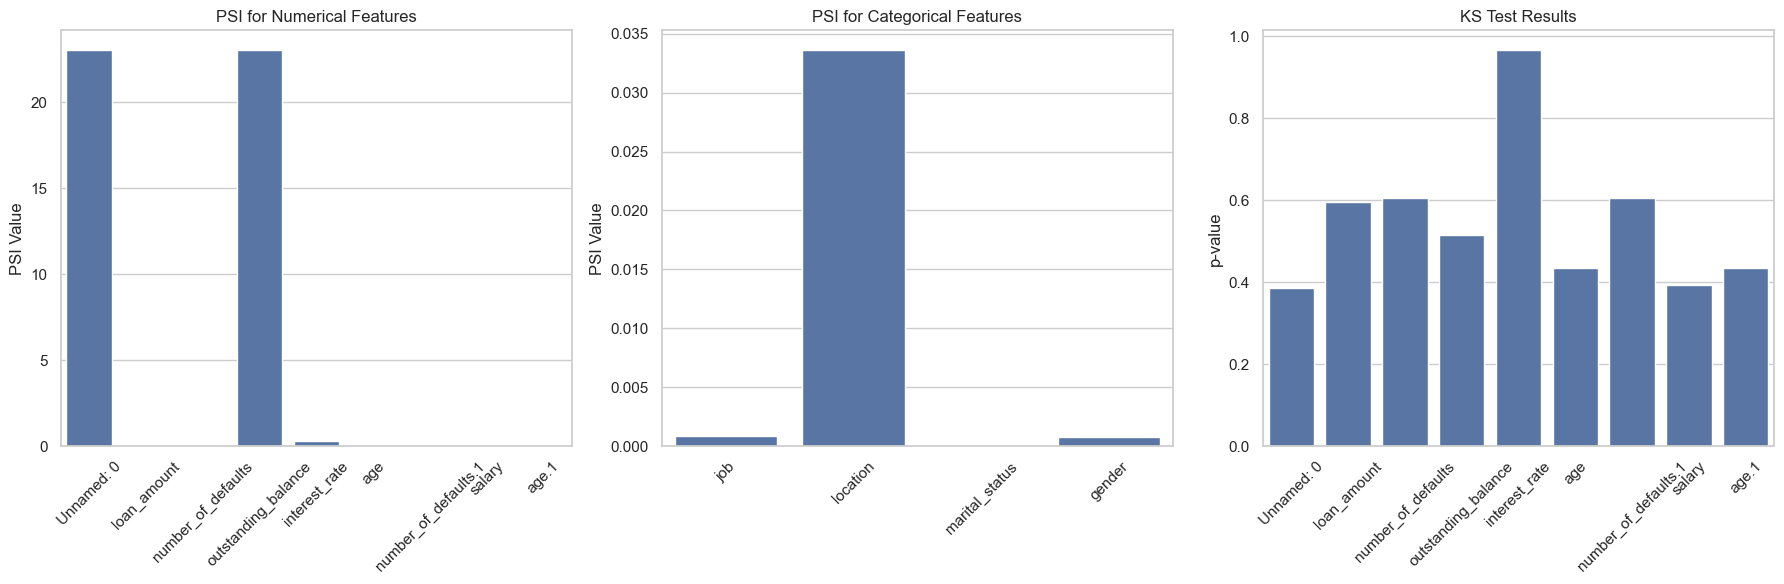

In [ ]:
# import our custom made DataDriftMonitor class
import data_drift 
importlib.reload(data_drift)
from data_drift import DataDriftMonitor

#instantiate our monitor with our training data
monitor = DataDriftMonitor(X_train)

# test on our test data
monitor.transform(X_test);

### Key Findings
- KS Test: All p-values are above 0.05, indicating no significant differences in the distributions of numerical features between the training and new data.
- PSI: High PSI values for outstanding_balance (23.03) and remaining term (23.03) suggest significant drift in these features.

### Importance of Monitoring Data Drift

Monitoring data drift is crucial for maintaining model performance for several reasons:

1. **Maintains Accuracy**: Ensures the model remains accurate as data distributions change over time.
2. **Addresses Concept Drift**: Detects shifts in underlying relationships between features and the target variable.
3. **Prevents Degradation**: Helps identify and address performance issues before they impact the model significantly.
4. **Enhances Reliability**: Demonstrates the robustness and dependability of the model in dynamic environments.
5. **Supports Continuous Improvement**: Allows iterative improvements by adapting to new data trends.
6. **Adapts to Real-World Changes**: Ensures the model stays relevant as real-world conditions evolve.

Regular monitoring of data drift helps keep the model accurate and relevant, improving overall performance and robustness.


# CREATE A PIPELINE



Set Up the Machine Learning Pipeline:

- Use custom data transformation classes to preprocess the data.
- Use the custom data drift detection class to monitor model perfomance and compatibility.
- Integrate the CatBoostClassifier into the pipeline for classification tasks.

Train the Model:

- Fit the pipeline to the training data, applying all transformations and training the classifier.

Evaluate the Model:

- Predict probabilities on the test set.
- Have the roc curve plot to assess the perfomance

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['remaining term', 'outstanding_balance',
                                  'interest_rate', 'age', 'loan_amount',
                                  'salary', 'is_employed']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['gender', 'marital_status',
                                  'number_of_defaults', 'job', 'location'])])
Predict_Marital Model Score: 0.9101819589624468
0:	learn: 0.6262495	total: 18.1ms	remaining: 18.1s
1:	learn: 0.5690286	total: 35.5ms	remaining: 17.7s
2:	learn: 0.5202160	total: 56.4ms	remaining: 18.7s
3:	learn: 0.4831506	total: 73.8ms	remaining: 18.4s
4:	learn: 0.4498

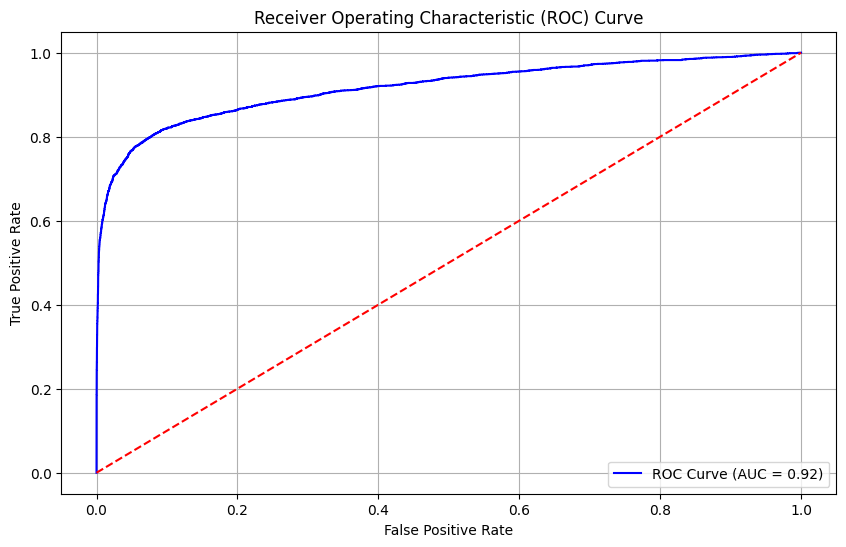

In [34]:
import importlib
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pipeline_process
import data_drift
importlib.reload(pipeline_process)
importlib.reload(data_drift)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

# Data Preparation
X = df1.drop(columns=['Loan Status', 'disbursemet_date', 'currency', 'country'])
y = df1['Loan Status'].map({'Did not default': 0, 'Defaulted': 1}).astype('int')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=87)






# Identify numerical and categorical columns
numerical_cols = ['remaining term', 'outstanding_balance', 'interest_rate', 'age', 'loan_amount', 'salary', 'is_employed',
                    'gender', 'marital_status', 'number_of_defaults', 'job', 'location']

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),


])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)


# Model and Pipeline Setup
clf = CatBoostClassifier(learning_rate = 0.07)
pipeline = Pipeline(steps=[
    # ('preprocessor', preprocessor),
    ('data_drift', data_drift.DataDriftMonitor(X_train, show_plots = False)),
    ('transformer', pipeline_process.DataTransformer(X_train, y_train)),
    ('transformer1', pipeline_process.Predict_Marital()),
    
    ('classifier', clf)
])

# Fit the pipeline (this will also train Predict_Marital)
model = pipeline.fit(X_train, y_train)
print()
# Predict probabilities
P = pipeline.predict_proba(X_val)[:,1]
roc_auc = roc_auc_score(y_val, P)
print(f'ROC AUC: {roc_auc:.2f}')



# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, P)
# 
# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

### PIPELINE REVIEW
- It retains our High ROC AUC SCORE of 0.92 (92%)
- It intergrates seamlessly our custom classes, models and preprocessing.

### Saving the Model

To save the trained model for future use, we use the `joblib` library. This allows us to serialize the model object and store it in a file. Here’s how you can do it:


In [35]:
import joblib

joblib.dump(model, 'model_file.pkl')

['model_file.pkl']

In [ ]:
model.predict(X_val)

1.0


array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

### **3. Next Steps**

Outline potential next steps or actions that could be taken based on the current state of the project.

```markdown
## Next Steps

1. **Model Deployment:** Deploy the saved model to a production environment or API endpoint.
2. **Further Evaluation:** Conduct additional testing with new data or on different subsets of data.
3. **Model Monitoring:** Implement monitoring to track the model's performance over time.
4. **Documentation:** Prepare detailed documentation for the model and its deployment process.
5. **Feature Enhancements:** Explore further feature engineering to potentially improve model performance